# **I. Import libraries, prepare environment and load data**

## 1. Import libaries

In [ ]:
!pip install torchinfo

In [ ]:
import copy
import os
import random
import glob
#import wandb
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
from typing import Dict, Tuple, List
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchinfo
import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

In [ ]:
base = nn.Identity()
base

Identity()

In [ ]:
# setting up device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## 2. Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# List the contents of the root directory of your Google Drive
root_dir = "/content/drive/My Drive"
print(os.listdir(root_dir))

['fff', '~..', 'LQĐ', 'CB284860-029A-4473-8CE6-8A06C274EB7F.jpeg', '085F6643-7F59-4173-92A9-51095751CE39.jpeg', '8B0247FE-E80A-4DB1-82BF-170C07B8ED68.jpeg', '9FF30C77-A4B9-44FC-BFF6-1FC882DB98BB.jpeg', 'DD926C30-549C-4A81-AF8E-7ED8C8888F9F.jpeg', 'D506FFAB-EE27-4E4D-8157-9904AB64061F.jpeg', '6828C3A5-EB32-4E91-9FC6-8982838B564F.jpeg', '011B36A7-4263-4AC4-B6E7-E3ACDC43EA72.jpeg', 'A98702ED-89FF-4D1A-86AA-FA8AC608B4DD.jpeg', '51D4FC55-2530-4857-B1C7-A86E684E2F94.jpeg', '6F9ECF52-7140-448E-A914-38E7A1CD5879.jpeg', '6A9BC147-0D51-4849-AEE4-C70CA2D92F7B.jpeg', 'BB17A0BE-A4E5-4BCE-A966-FF6E50215258.jpeg', '6892BEFB-63C1-48E7-8004-3B50ED58E7A5.jpeg', 'C5FBA579-DE61-416C-B0E1-B16D6932C2AC.jpeg', '4E913B57-6EBE-4EC8-98F0-43EEF89EE52E.jpeg', 'Thư mục không có tiêu đề', 'IMG_8034.jpg', 'Edited', 'New folder (4)', '_MG_0268.jpg', '_MG_0359.jpg', '_MG_0273.jpg', '_MG_0283.jpg', '_MG_0420.jpg', '_MG_0293.jpg', '_MG_0306.jpg', '_MG_0310.jpg', '_MG_0424.jpg', '_MG_0312.jpg', '_MG_0465.jpg', '_M

In [ ]:
# data dir
ROOT_DIR = '/content/drive/MyDrive/Milan-Urban-Farming/Task3-Smart Pest Management/Data collection/Image Collection/orange - Swathy/Orange fruit_Split'
print(os.listdir(ROOT_DIR ))

['train', 'test', 'validation']


## 3. Creating Custom Dataset for PyTorch DataLoading

In [ ]:
# CustomDataset class for multi-class image classification
class CustomDataset(Dataset):


    def __init__(self, root_dir: str, split: str, transform=None, resize=None):
        """
        Custom dataset class for multi-class image classification.

        Args:
            root_dir (str): Root directory containing the dataset.
            split (str): Split (e.g., train, validation) of the dataset.
            transform (callable, optional): Optional transformation to apply to the data.
            resize (int, optional): Resize dimensions (width, height) for the images.

        Attributes:
            root_dir (str): Root directory containing the dataset.
            split (str): Split (e.g., train, validation) of the dataset.
            transform (callable, optional): Optional transformation to apply to the data.
            resize (int, optional): Resize dimensions (width, height) for the images.
            data (list): List of image paths.
            targets (list): List of target labels.
            class_names (list): List of class names.
            class_idx_to_name (dict): Dictionary mapping class indices to class names.

        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.resize = resize
        self.data = []
        self.targets = []
        self.class_names = []


        # Determine the data directory based on the split
        data_dir = os.path.join(root_dir, split)

        # Walk through the class subfolders
        class_dirs = sorted(os.listdir(data_dir))
        for class_idx, class_dir in enumerate(class_dirs):
            class_path = os.path.join(data_dir, class_dir)
            self.class_names.append(class_dir)

            # Walk through the images in each class subfolder
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.data.append(img_path)
                self.targets.append(class_idx)
        # Create a dictionary to map class indices to class names
        self.class_idx_to_name = {idx: name for idx, name in enumerate(self.class_names)}
        # Method to get the length of the dataset
    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
            int: The number of images in the dataset.
        """
        return len(self.data)

    # Method to get a specific item from the dataset
    def __getitem__(self, idx):
        """
        Get a specific item from the dataset.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing the processed image and its target label.
                If an error occurs during image loading or processing, returns (None, None).
        """
        img_path = self.data[idx]
        target = self.targets[idx]

        try:
            image = cv2.imread(img_path)

            if self.resize is not None:
                image = cv2.resize(image, (self.resize, self.resize))

            if self.transform is not None:
                image = self.transform(image=image)['image']

            return image, target

        except Exception as e:
            print(f"Error loading image: {e}")
            return None, None

    def num_classes(self):
        """
        Get the number of classes in the dataset.

        Returns:
            int: Number of classes.
        """
        return len(self.class_names)


    def get_class_name(self, class_idx):
        """
        Get the class name based on its index.

        Args:
            class_idx (int): Index of the class.

        Returns:
            str: The name of the class.
        """
        return self.class_idx_to_name.get(class_idx)

    def get_class_names(self):
        """
        Get all class names in the dataset.

        Returns:
            list: A list of class names.
        """
        return list(self.class_idx_to_name.values())

    def class_idx_to_name_dict(self):
        """
        Get a dictionary mapping class indices to class names.

        Returns:
            dict: A dictionary mapping class indices to class names.
        """
        return self.class_idx_to_name



    def get_class_frequencies(self):
        """
        Calculate and return a dictionary containing the number of samples for each class.

        Returns:
            dict: A dictionary with class indices as keys and sample counts as values.
        """
        class_counts = {}
        for label in self.targets:
            if label not in class_counts:
                class_counts[label] = 0
            class_counts[label] += 1
        return class_counts


# **II. Model training**

## **1. Necessary Functions**

### 1.1. Image Augmentations

In [ ]:
def get_transforms(config:Dict, augment=True):
    """
    Get data augmentation and transformation pipelines for image data.

    Args:
        augment (bool, optional): Whether to apply data augmentation. Default is True.

    Returns:
        tuple: A tuple containing the training and validation transformation pipelines.

    Notes:
        - If augment is True, applies a set of augmentation techniques including horizontal flip, vertical flip,
          random rotation, random brightness/contrast adjustments, hue/saturation/value adjustments, noise addition,
          CLAHE, and normalization with specified mean and standard deviation.
        - If augment is False, applies only normalization with specified mean and standard deviation.

    Example:
        train_transform = get_transforms(augment=True)
    """
    if augment:
        transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.3),
            A.RandomBrightnessContrast(brightness_limit=(-0.15,0.15), contrast_limit=(-0.15, 0.15), p=0.3),
            # A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=20, p=0.2),
            A.GaussNoise(var_limit=(10, 50), p=0.1),
            A.CLAHE(clip_limit=(1,3), tile_grid_size=(8, 8), p=0.3),
            A.RandomCrop(600, 600, 0.3),  # RandomCrop to introduce variability
            A.CenterCrop(height=config['crop'], width=config['crop']),  # CenterCrop to focus on central area
            # choose mean and std based on pre-trained model specification.
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
            ])
    else:
        transform = A.Compose([
            A.CenterCrop(height=config['crop'], width=config['crop']),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])


    return transform

### 1.2. Model Training Loop

In [ ]:
def train_model(model, dataloader, optimizer, loss_fn, device):
    """
    Trains a model on a given dataset using a specified optimizer and loss function.

    Args:
        model (torchvision.models): The model to be trained.
        dataloader (DataLoader): The data loader for the training dataset.
        optimizer (optim.Optimizer): The optimizer used to update the model parameters.
        loss_fn (nn.Module): The loss function used to calculate the loss.
        device (torch.device): The device (e.g., GPU or CPU) to use for training.

    Returns:
        dict: A dictionary containing the training results, including the average loss, accuracy, precision, recall, and F1-score.
    """

    # Set the model to training mode
    model.train()

    # Initialize running totals for loss and correct predictions
    running_loss = 0.0
    running_corrects = 0
    true_labels, predicted_labels = [], []

    # Loop over the data
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss and correct predictions
        running_loss += loss.item() * images.size(0)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        # Collect true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

    # Calculate average loss and accuracy over the entire dataset
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Return detailed training results
    training_results = {
        'Loss': epoch_loss,
        'Accuracy': epoch_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Macro': f1,
    }

    return training_results

### 1.3. Model Validation Loop

In [ ]:
def validate_model(model, dataloader, loss_fn, device):
    """
    Evaluates the model on a validation dataset.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        dataloader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        loss_fn (torch.nn.Module): Loss function to evaluate the model's performance.
        device (str): Device to perform computations on (e.g., 'cpu' or 'cuda').

    Returns:
        dict: A dictionary containing the average loss, accuracy, precision, recall, and F1 score (macro).
    """

    # Set the model to evaluation mode
    model.eval()

    # Initialize running totals for loss and correct predictions
    running_loss = 0.0
    running_corrects = 0
    true_labels, predicted_labels = [], []

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Loop over the data
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Accumulate loss and correct predictions
            running_loss += loss.item() * images.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

            # Collect true and predicted labels
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

    # Calculate average loss and accuracy over the entire dataset
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Return detailed validation results
    validation_results = {
        'Loss': epoch_loss,
        'Accuracy': epoch_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Macro': f1,
    }

    # Reset the model to training mode
    model.train()

    return validation_results

### 1.4. Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

### **1.5. Training Pipeline**

#### ***A. Normal training***

In [ ]:
def training_pipeline(config:Dict,
                      model:models,
                      train_loader:DataLoader,
                      valid_loader:DataLoader,
                      optimizer:optim.Optimizer,
                      loss_fn:nn.Module,
                      early_stopping: None or object,
                      device:str):
    """
    Function to manage the training pipeline of a machine learning model.

    Args:
        config (Dict): A dictionary containing configuration parameters, including the number of epochs.
        model (torchvision.models): The model to be trained.
        train_loader (DataLoader): DataLoader for the training dataset.
        valid_loader (DataLoader): DataLoader for the validation dataset.
        optimizer (optim.Optimizer): Optimizer for model parameter updates.
        loss_fn (nn.Module): Loss function to evaluate the model's performance.
        device (str): Device to perform computations (e.g., 'cpu' or 'cuda').

    Returns:
        None
    """
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }
    best_val_f1 = 0.0
    best_model_state_dict = None

    for epoch in tqdm(range(config['epochs'])):
        print(f'Epoch {epoch + 1}/{config["epochs"]}')
        print('-' * 10)

        train_res = train_model(model=model,
                                dataloader=train_loader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

        print(f"Train - Loss: {train_res['Loss']:.4f}, Accuracy: {train_res['Accuracy']:.4f}, Precision: {train_res['Precision']:.4f}, Recall: {train_res['Recall']:.4f}, F1 Score: {train_res['F1-Macro']:.4f}")

        val_res = validate_model(model=model,
                                dataloader=valid_loader,
                                loss_fn=loss_fn,
                                device=device)
        print(f"Validation - Loss: {val_res['Loss']:.4f}, Accuracy: {val_res['Accuracy']:.4f}, Precision: {val_res['Precision']:.4f}, Recall: {val_res['Recall']:.4f}, F1 Score: {val_res['F1-Macro']:.4f}")

         # Save the results
        history['train_loss'].append(train_res['Loss'])
        history['train_accuracy'].append(train_res['Accuracy'])
        history['train_precision'].append(train_res['Precision'])
        history['train_recall'].append(train_res['Recall'])
        history['train_f1'].append(train_res['F1-Macro'])

        history['val_loss'].append(val_res['Loss'])
        history['val_accuracy'].append(val_res['Accuracy'])
        history['val_precision'].append(val_res['Precision'])
        history['val_recall'].append(val_res['Recall'])
        history['val_f1'].append(val_res['F1-Macro'])

        # Check early stopping
        if early_stopping:
            if early_stopping(model, val_res['Loss']):
                print(early_stopping.status)
                break
            else:
                print(early_stopping.status)

        # Deep copy the model if it has the best F1 score so far
        if val_res['F1-Macro'] > best_val_f1:
            best_val_f1 = val_res['F1-Macro']
            best_model_state_dict = copy.deepcopy(model.state_dict())
        print()

     # Load best model weights for validation loss (if applicable)
    if early_stopping and early_stopping.restore_best_weights:
        model.load_state_dict(early_stopping.best_model)
    else:
        model.load_state_dict(best_model_state_dict)

    # Save the best model after after training and validation
    if best_model_state_dict is not None:
        torch.save(best_model_state_dict, os.path.join('/content/drive/MyDrive/Orange Task 3', config['weights_path']))

    return history

#### ***B. Learning Rate Scheduling Training***

In [ ]:
def training_pipeline_2(
    config:Dict,
    model:models,
    train_loader:DataLoader,
    valid_loader:DataLoader,
    optimizer:optim.Optimizer,
    loss_fn:nn.Module,
    early_stopping: None or object,
    device:str
):
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate decay
    best_val_f1 = 0.0
    best_model_state_dict = None
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    for epoch in tqdm(range(config['epochs']), desc="Training Epochs"):
        print(f'Epoch {epoch + 1}/{config["epochs"]}')
        print('-' * 10)
        train_res = train_model(model, train_loader, optimizer, loss_fn, device)
        print(f"Train - Loss: {train_res['Loss']:.4f}, Accuracy: {train_res['Accuracy']:.4f}, Precision: {train_res['Precision']:.4f}, Recall: {train_res['Recall']:.4f}, F1 Score: {train_res['F1-Macro']:.4f}")

        val_res = validate_model(model, valid_loader, loss_fn, device)
        print(f"Validation - Loss: {val_res['Loss']:.4f}, Accuracy: {val_res['Accuracy']:.4f}, Precision: {val_res['Precision']:.4f}, Recall: {val_res['Recall']:.4f}, F1 Score: {val_res['F1-Macro']:.4f}")

        history['train_loss'].append(train_res['Loss'])
        history['train_accuracy'].append(train_res['Accuracy'])
        history['train_precision'].append(train_res['Precision'])
        history['train_recall'].append(train_res['Recall'])
        history['train_f1'].append(train_res['F1-Macro'])
        history['val_loss'].append(val_res['Loss'])
        history['val_accuracy'].append(val_res['Accuracy'])
        history['val_precision'].append(val_res['Precision'])
        history['val_recall'].append(val_res['Recall'])
        history['val_f1'].append(val_res['F1-Macro'])

        scheduler.step()  # Adjust learning rate after each epoch

        # Check early stopping
        if early_stopping:
            if early_stopping(model, val_res['Loss']):
                print(early_stopping.status)
                break
            else:
                print(early_stopping.status)

        # Deep copy the model if it has the best F1 score so far
        if val_res['F1-Macro'] > best_val_f1:
            best_val_f1 = val_res['F1-Macro']
            best_model_state_dict = copy.deepcopy(model.state_dict())
        print()

        if val_res['F1-Macro'] > best_val_f1:
            best_val_f1 = val_res['F1-Macro']
            best_model_state_dict = copy.deepcopy(model.state_dict())
     # Load best model weights for validation loss (if applicable)
    if early_stopping and early_stopping.restore_best_weights:
        model.load_state_dict(early_stopping.best_model)
    else:
        model.load_state_dict(best_model_state_dict)

    if best_model_state_dict:
        model.load_state_dict(best_model_state_dict)
        torch.save(best_model_state_dict, os.path.join('/content/drive/MyDrive/Orange Task 3', config['weights_path']))

    return history


### **1.6. Plotting Training Results**

In [ ]:
def plot_training_results(history):
  """
  Plot training and validation loss and F1-score from training history.

  Args:
      history (Dict): Dictionary containing training and validation results for each epoch.
          Expected keys: 'train_loss', 'val_loss', 'train_f1', 'val_f1'
  """
  plt.figure(figsize=(20, 12))

  # Plot loss
  plt.subplot(2, 1, 1)
  plt.plot(history['train_loss'], label='Train Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  # Plot F1-score
  plt.subplot(2, 1, 2)
  plt.plot(history['train_f1'], label='Train F1-Score')
  plt.plot(history['val_f1'], label='Validation F1-Score')
  plt.xlabel('Epoch')
  plt.ylabel('F1-Score')
  plt.title('Training and Validation F1-Score')
  plt.legend()

  plt.tight_layout()
  plt.show()

### **1.7. Evaluation**

In [ ]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)

    # Additional per-class evaluation (optional)
    class_report = classification_report(y_true, y_pred)

    return cm, f1_macro, precision, recall, accuracy, class_report

In [ ]:
def plot_cm(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(20,15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Set3',xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

## **2. Model Training without Augmentation**

### **2.1. Training prepare**

#### **A. Check for directory**

In [ ]:
# Check if the directory exists
if not os.path.exists(ROOT_DIR):
    raise FileNotFoundError("Directory does not exist:", ROOT_DIR)

# Check if the train directory exists
if not os.path.exists(os.path.join(ROOT_DIR, 'train')):
    raise FileNotFoundError("Train directory does not exist:", os.path.join(ROOT_DIR, 'train'))

### **2.2.ResNet 18**

In [ ]:
# Resnet 18 v1
config_resnet = dict(
    resize =1365,
    crop = 1024,
    augment= False,
    epochs = 50,
    batch_size = 32,
    lr = 0.001,
    dropout = 0.2,
    weights_path = 'weights_basic_resnet_18.pth'
)

#### **A. Create Data Loader**

In [ ]:
# get transforms
train_transform = get_transforms(augment=config_resnet['augment'], config=config_resnet)
valid_transform = get_transforms(augment=config_resnet['augment'], config=config_resnet)
# dataset
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config_resnet['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation', resize=config_resnet['resize'], transform=valid_transform)
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=config_resnet['batch_size'], shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=config_resnet['batch_size'], shuffle=False, num_workers=4)

In [ ]:
es = EarlyStopping(patience=5, min_delta=0.01, restore_best_weights=False)

In [ ]:
num_classes = train_dataset.num_classes()
print("No. of Classes : ", num_classes)

No. of Classes :  8


In [ ]:
class_map = train_dataset.class_idx_to_name_dict()
print("Class Index to class name map: \n")
class_map

Class Index to class name map: 



{0: 'Black spot',
 1: 'Canker',
 2: 'Greening',
 3: 'Scab',
 4: 'bacteria _citrus',
 5: 'fungus_penicillium',
 6: 'healthy',
 7: 'pest_psyllid'}

In [ ]:
# class frequencies
class_freq = train_loader.dataset.get_class_frequencies()
class_freq

{0: 180, 1: 223, 2: 308, 3: 12, 4: 23, 5: 34, 6: 328, 7: 19}

In [ ]:
total_samples = sum(class_freq.values())
num_classes = len(class_freq)

class_weights = [round(total_samples / (num_classes * class_freq[i]), 4) for i in range(num_classes)]
print(class_weights)

[0.7826, 0.6317, 0.4574, 11.7396, 6.125, 4.1434, 0.4295, 7.4145]


Labels: tensor([2, 6, 1, 0, 2, 6, 1, 2, 0, 2, 1, 6, 1, 6, 1, 6, 2, 6, 5, 6, 2, 4, 3, 6,
        0, 1, 1, 2, 0, 7, 2, 0])


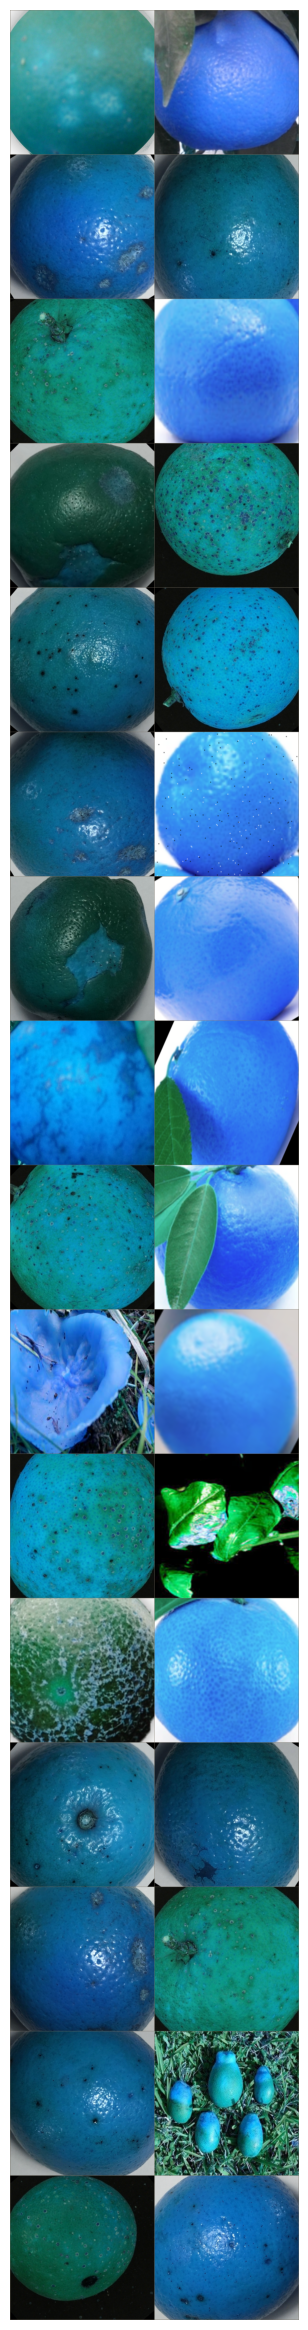

In [ ]:
# Fetch the first batch of images and labels from the train_loader
for images, labels in train_loader:
    break

# Print the labels
print('Labels:', labels)

# Make the grid with 2 rows and 8 columns
im = make_grid(images, nrow=2)  # nrow changed to 8 for 2x8 grid

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Increase the figure size
plt.figure(figsize=(40, 30))  # increased figure size

# Display the images grid
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))
plt.axis('off')  # Turn off axis labels
plt.show()

#### **B. Training**

In [ ]:
# initialise pre-trained weights
weights = models.ResNet18_Weights.IMAGENET1K_V1
# initialize the model
resnet18 = models.resnet18(weights='IMAGENET1K_V1', progress=True)
# Freeze the pre-trained model parameters
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the last fully connected layer
resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, 1024),
    nn.ReLU(),
    nn.Dropout(config_resnet['dropout']),
    nn.Linear(in_features=1024, out_features= num_classes),
    nn.Softmax(dim=1)
)

# Move the model to the specified device
resnet18 = resnet18.to(device)

In [ ]:
# define optimizer and loss funtion
optimizer = optim.Adam(params=resnet18.parameters(), lr=config_resnet['lr'])
loss_fn = nn.CrossEntropyLoss()

# Start training
history  = training_pipeline(config=config_resnet,
                  model = resnet18,
                  train_loader=train_loader,
                  valid_loader=valid_loader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  early_stopping=None,
                  device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
----------
Train - Loss: 1.6356, Accuracy: 0.6376, Precision: 0.1767, Recall: 0.2454, F1 Score: 0.1972
Validation - Loss: 1.6275, Accuracy: 0.6471, Precision: 0.1797, Recall: 0.2478, F1 Score: 0.2000

Epoch 2/50
----------
Train - Loss: 1.6351, Accuracy: 0.6376, Precision: 0.1759, Recall: 0.2452, F1 Score: 0.1969
Validation - Loss: 1.6322, Accuracy: 0.6405, Precision: 0.1712, Recall: 0.2449, F1 Score: 0.1958

Epoch 3/50
----------
Train - Loss: 1.6371, Accuracy: 0.6376, Precision: 0.1760, Recall: 0.2454, F1 Score: 0.1970
Validation - Loss: 1.6270, Accuracy: 0.6471, Precision: 0.1797, Recall: 0.2478, F1 Score: 0.2000

Epoch 4/50
----------
Train - Loss: 1.6194, Accuracy: 0.6489, Precision: 0.2310, Recall: 0.2573, F1 Score: 0.2371
Validation - Loss: 1.6694, Accuracy: 0.6013, Precision: 0.1967, Recall: 0.2508, F1 Score: 0.1972

Epoch 5/50
----------
Train - Loss: 1.6508, Accuracy: 0.6208, Precision: 0.2116, Recall: 0.2417, F1 Score: 0.2106
Validation - Loss: 1.6282, Accuracy: 0

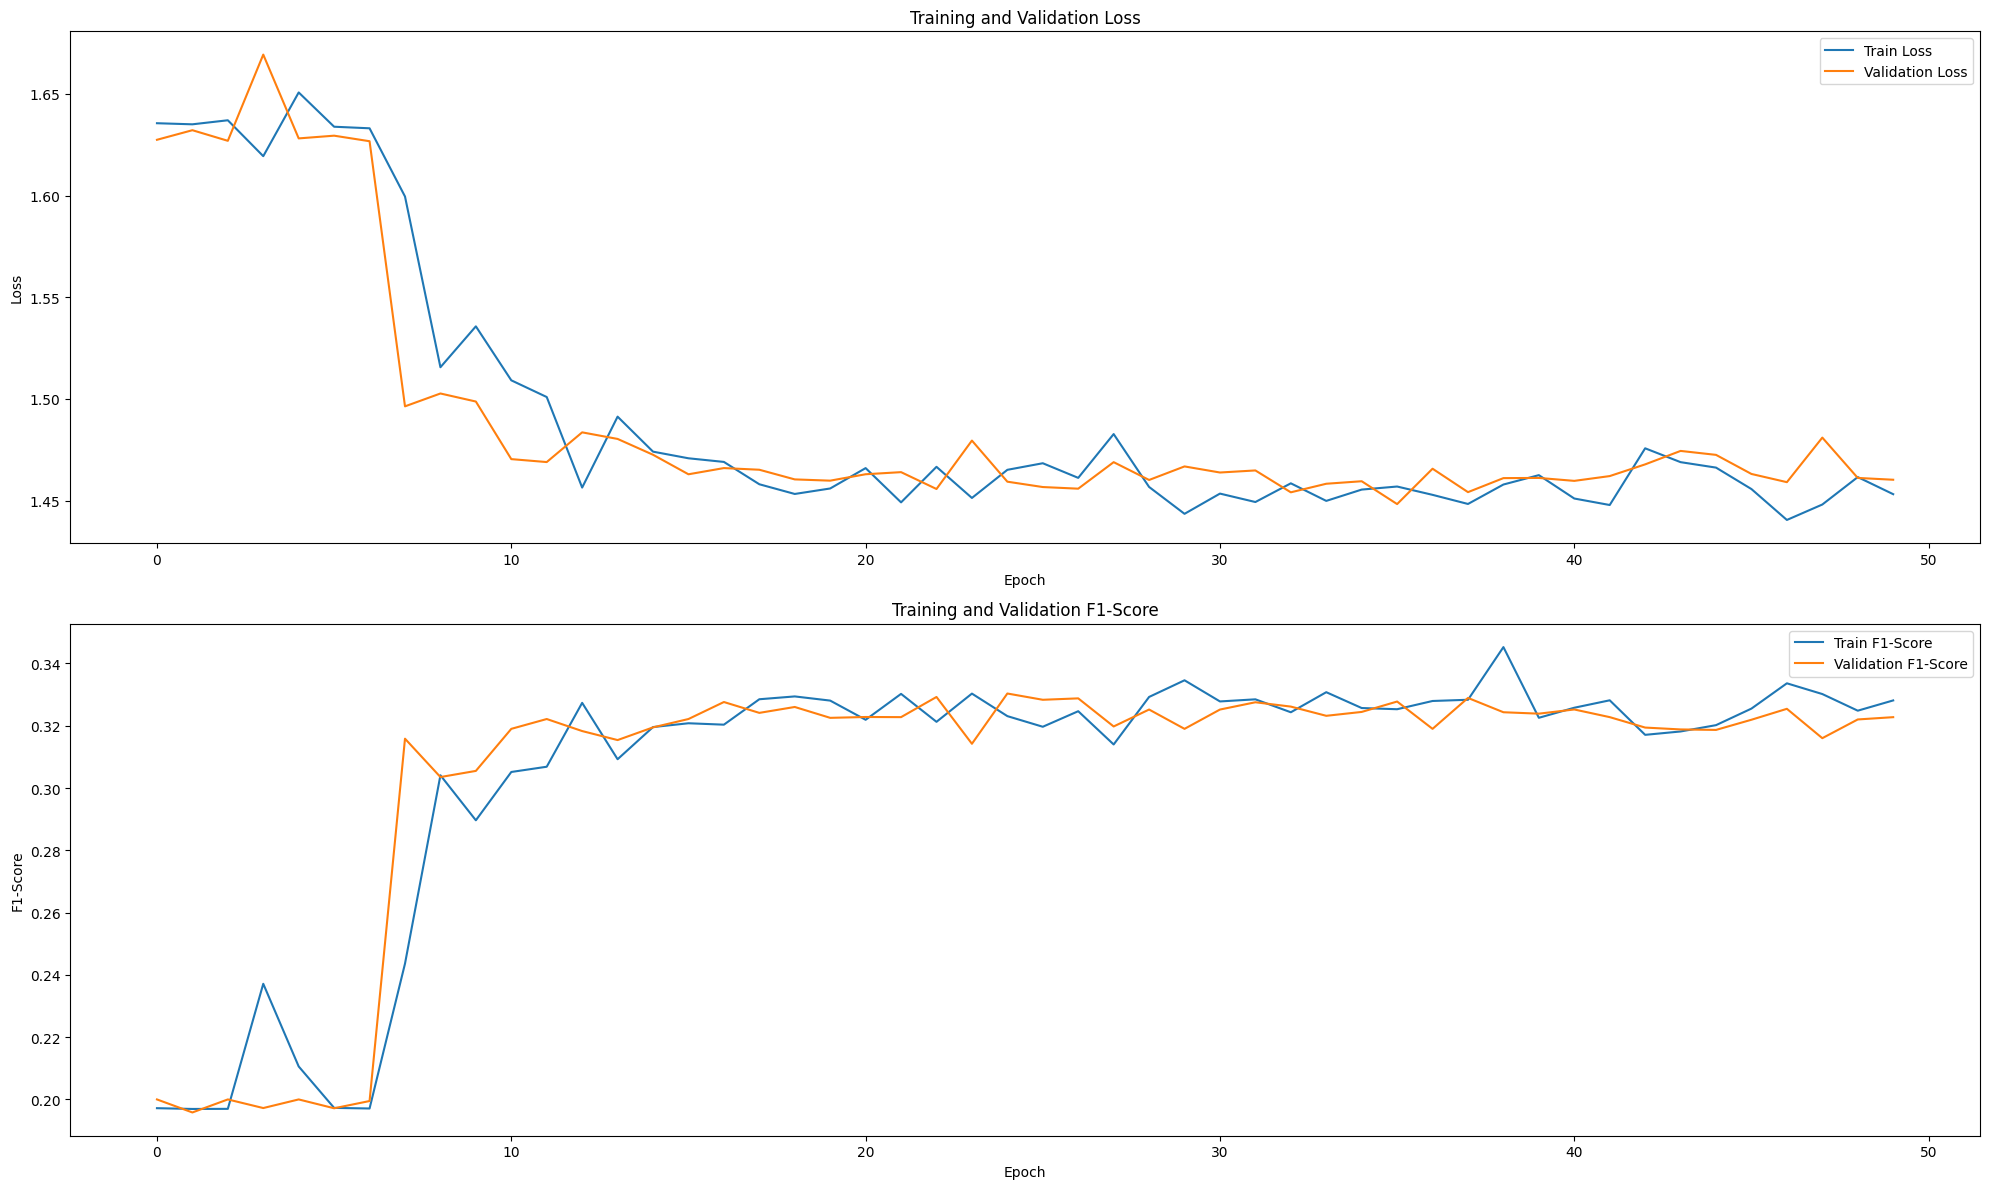

In [ ]:
plot_training_results(history=history)

In [ ]:
#dataset
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test',resize=config_resnet['resize'], transform=valid_transform)
# dataloaders
test_loader = DataLoader(test_dataset, batch_size=config_resnet['batch_size'], shuffle=False, num_workers=4)

In [ ]:
class_map = train_dataset.class_idx_to_name_dict()
print(class_map)

{0: 'Black spot', 1: 'Canker', 2: 'Greening', 3: 'Scab', 4: 'bacteria _citrus', 5: 'fungus_penicillium', 6: 'healthy', 7: 'pest_psyllid'}


In [ ]:
classes = test_dataset.class_names
print(classes)

['Black spot', 'Canker', 'Greening', 'Scab', 'bacteria _citrus', 'fungus_penicillium', 'healthy', 'pest_psyllid']


In [ ]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=resnet18, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.8089, Precision: 0.3209, Recall: 0.3536, F1 Score: 0.3342
Classification Report : 

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        34
           1       0.86      0.90      0.88        42
           2       0.70      0.98      0.82        58
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4

    accuracy                           0.81       157
   macro avg       0.32      0.35      0.33       157
weighted avg       0.71      0.81      0.75       157



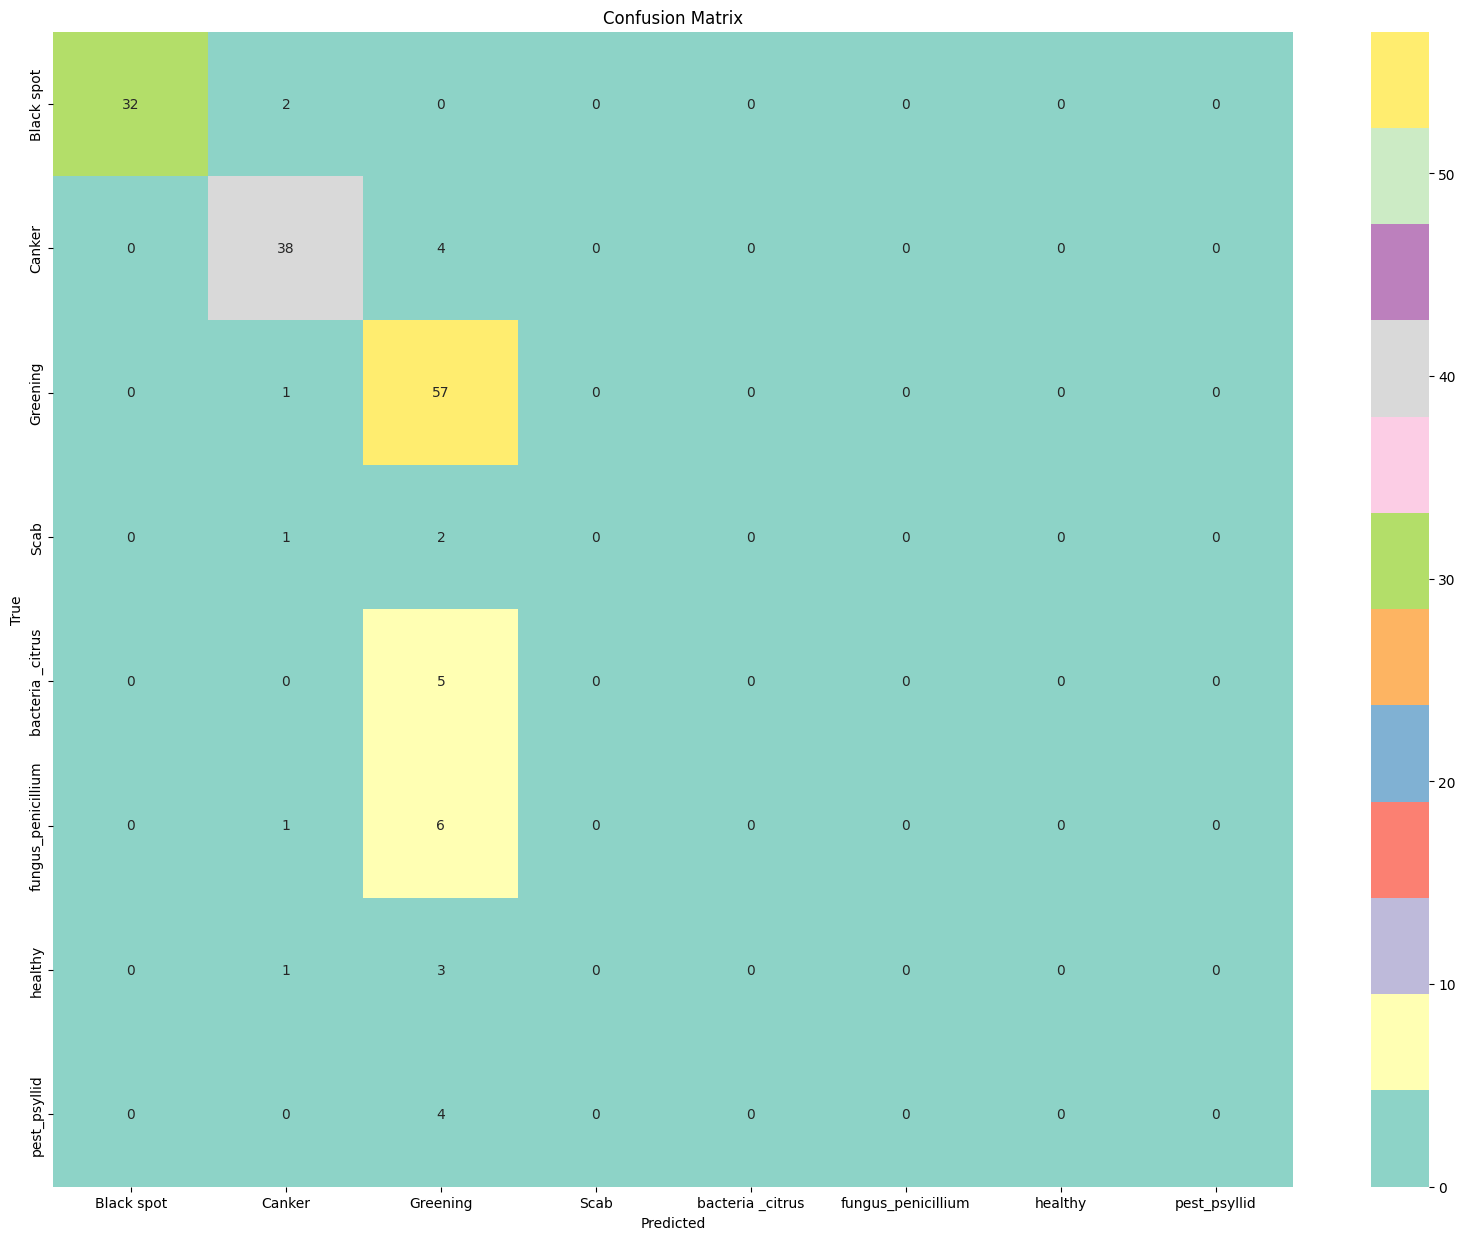

In [ ]:
# plot confusion matrix
plot_cm(cm, classes, title="Confusion Matrix")

### **2.5. EfficientNet B1 [2]**

Update: resize=256, crop=240, applied WeightedRandomSampler in Data Loader to balance out classes, applied Early Stopping in training.


In [ ]:
# Efficient Net B1 v2
config_ef_v2 = dict(
    resize =256,
    crop = 240,
    augment= False,
    epochs = 50,
    batch_size = 32,
    lr = 0.001,
    dropout = 0.2,
    weights_path = 'weights_basic_EFnet_v2.pth'
)

#### **A. Create Data Loader**

In [ ]:
# Get transformations
train_transform = get_transforms(config=config_ef_v2, augment=config_ef_v2['augment'])
val_test_transform = get_transforms(config=config_ef_v2, augment=False)
# dataset
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config_ef_v2['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation',resize=config_ef_v2['resize'], transform=val_test_transform)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test',resize=config_ef_v2['resize'], transform=val_test_transform )
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=config_ef_v2['batch_size'], shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=config_ef_v2['batch_size'], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config_ef_v2['batch_size'], shuffle=False, num_workers=4)

#### **B. Balance out classes**

In [ ]:
# Assign Weights to Each Sample
sample_weights = [class_weights[label] for _, label in train_loader.dataset] # The class weights are calculated in: 2.2.ResNet 18

# Convert list of sample weights to a Torch tensor
sample_weights = torch.tensor(sample_weights)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Dataloaders setup
train_loader_balanced = DataLoader(train_dataset, batch_size=config_ef_v2['batch_size'], sampler=sampler, num_workers=4)

In [ ]:
# Initialize a dictionary to count occurrences of each class
num_classes = len(class_weights)  # Ensure class_weights is accessible here
class_count = {i: 0 for i in range(num_classes)}

# Iterate through batches and count after balancing classes
for data, labels in train_loader_balanced:
    for label in labels:
        class_count[label.item()] += 1

# Print class frequencies
print("Class frequencies after balancing:")
for class_id, count in class_count.items():
    print(f"Class {class_id}: {count}")

Class frequencies after balancing:
Class 0: 86
Class 1: 80
Class 2: 90
Class 3: 93
Class 4: 86
Class 5: 91
Class 6: 101
Class 7: 85


In [ ]:
class_count_before = {i: 0 for i in range(num_classes)}

# Iterate through batches and count after balancing classes
for data, labels in train_loader:
    for label in labels:
        class_count_before[label.item()] += 1

# Print class frequencies
print("Class frequencies before balancing:")
for class_id, count in class_count_before.items():
    print(f"Class {class_id}: {count}")

Class frequencies before balancing:
Class 0: 157
Class 1: 195
Class 2: 269
Class 3: 10
Class 4: 20
Class 5: 30
Class 6: 15
Class 7: 16


Labels: tensor([1, 2, 7, 5, 4, 0, 0, 7, 5, 5, 3, 4, 4, 0, 0, 1, 5, 5, 4, 6, 6, 1, 1, 0,
        6, 0, 6, 7, 1, 3, 0, 2])


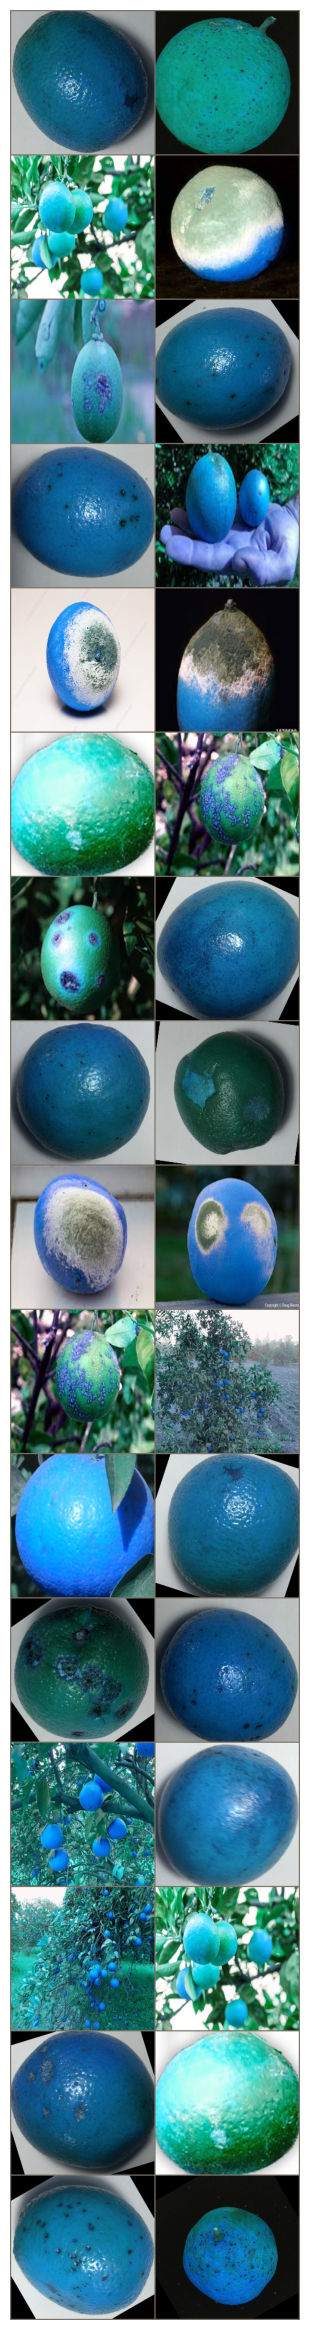

In [ ]:
# Fetch the first batch of images and labels from the train_loader
for images, labels in train_loader_balanced:
    break

# Print the labels
print('Labels:', labels)

# Make the grid with 2 rows and 8 columns
im = make_grid(images, nrow=2)  # nrow changed to 8 for 2x8 grid

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Increase the figure size
plt.figure(figsize=(40, 30))  # increased figure size

# Display the images grid
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))
plt.axis('off')  # Turn off axis labels
plt.show()

#### **C. Model Training**

In [ ]:
es = EarlyStopping(patience=10, min_delta=0.01, restore_best_weights=False)

In [ ]:
model_ef_v2 = models.efficientnet_b1(weights='DEFAULT', progress=True)
num_ftrs = model_ef_v2.classifier[1].in_features
# Freeze the pre-trained model parameters
for param in model_ef_v2.parameters():
    param.requires_grad = False
model_ef_v2.classifier = nn.Sequential(
                nn.Dropout(p=config_ef_v2["dropout"], inplace=True),
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(),
                nn.Dropout(p=config_ef_v2["dropout"]),
                nn.Linear(1024, num_classes)
            )
model_ef_v2 = model_ef_v2.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 72.3MB/s]


In [ ]:
# define optimizer and loss funtion
optimizer_ef_v2 = optim.Adam(params=model_ef_v2.parameters(), lr=config_ef_v2['lr'])
loss_fn = nn.CrossEntropyLoss()
history_5  = training_pipeline(config=config_ef_v2,
                  model = model_ef_v2,
                  train_loader=train_loader_balanced,
                  valid_loader=valid_loader,
                  optimizer=optimizer_ef_v2,
                  loss_fn=loss_fn,
                  early_stopping=es,
                  device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
----------
Train - Loss: 1.1210, Accuracy: 0.7388, Precision: 0.7461, Recall: 0.7422, F1 Score: 0.7297
Validation - Loss: 0.5227, Accuracy: 0.8497, Precision: 0.6581, Recall: 0.7847, F1 Score: 0.6867


Epoch 2/50
----------
Train - Loss: 0.3127, Accuracy: 0.9003, Precision: 0.8973, Recall: 0.8990, F1 Score: 0.8969
Validation - Loss: 0.3969, Accuracy: 0.8758, Precision: 0.7444, Recall: 0.8374, F1 Score: 0.7636
Improvement found, counter reset to 0

Epoch 3/50
----------
Train - Loss: 0.1958, Accuracy: 0.9382, Precision: 0.9370, Recall: 0.9350, F1 Score: 0.9349
Validation - Loss: 0.3258, Accuracy: 0.8889, Precision: 0.7522, Recall: 0.8440, F1 Score: 0.7780
Improvement found, counter reset to 0

Epoch 4/50
----------
Train - Loss: 0.1140, Accuracy: 0.9677, Precision: 0.9652, Recall: 0.9662, F1 Score: 0.9654
Validation - Loss: 0.3244, Accuracy: 0.8758, Precision: 0.7315, Recall: 0.8388, F1 Score: 0.7647
No improvement in the last 1 epochs

Epoch 5/50
----------
Train - Loss: 0.1

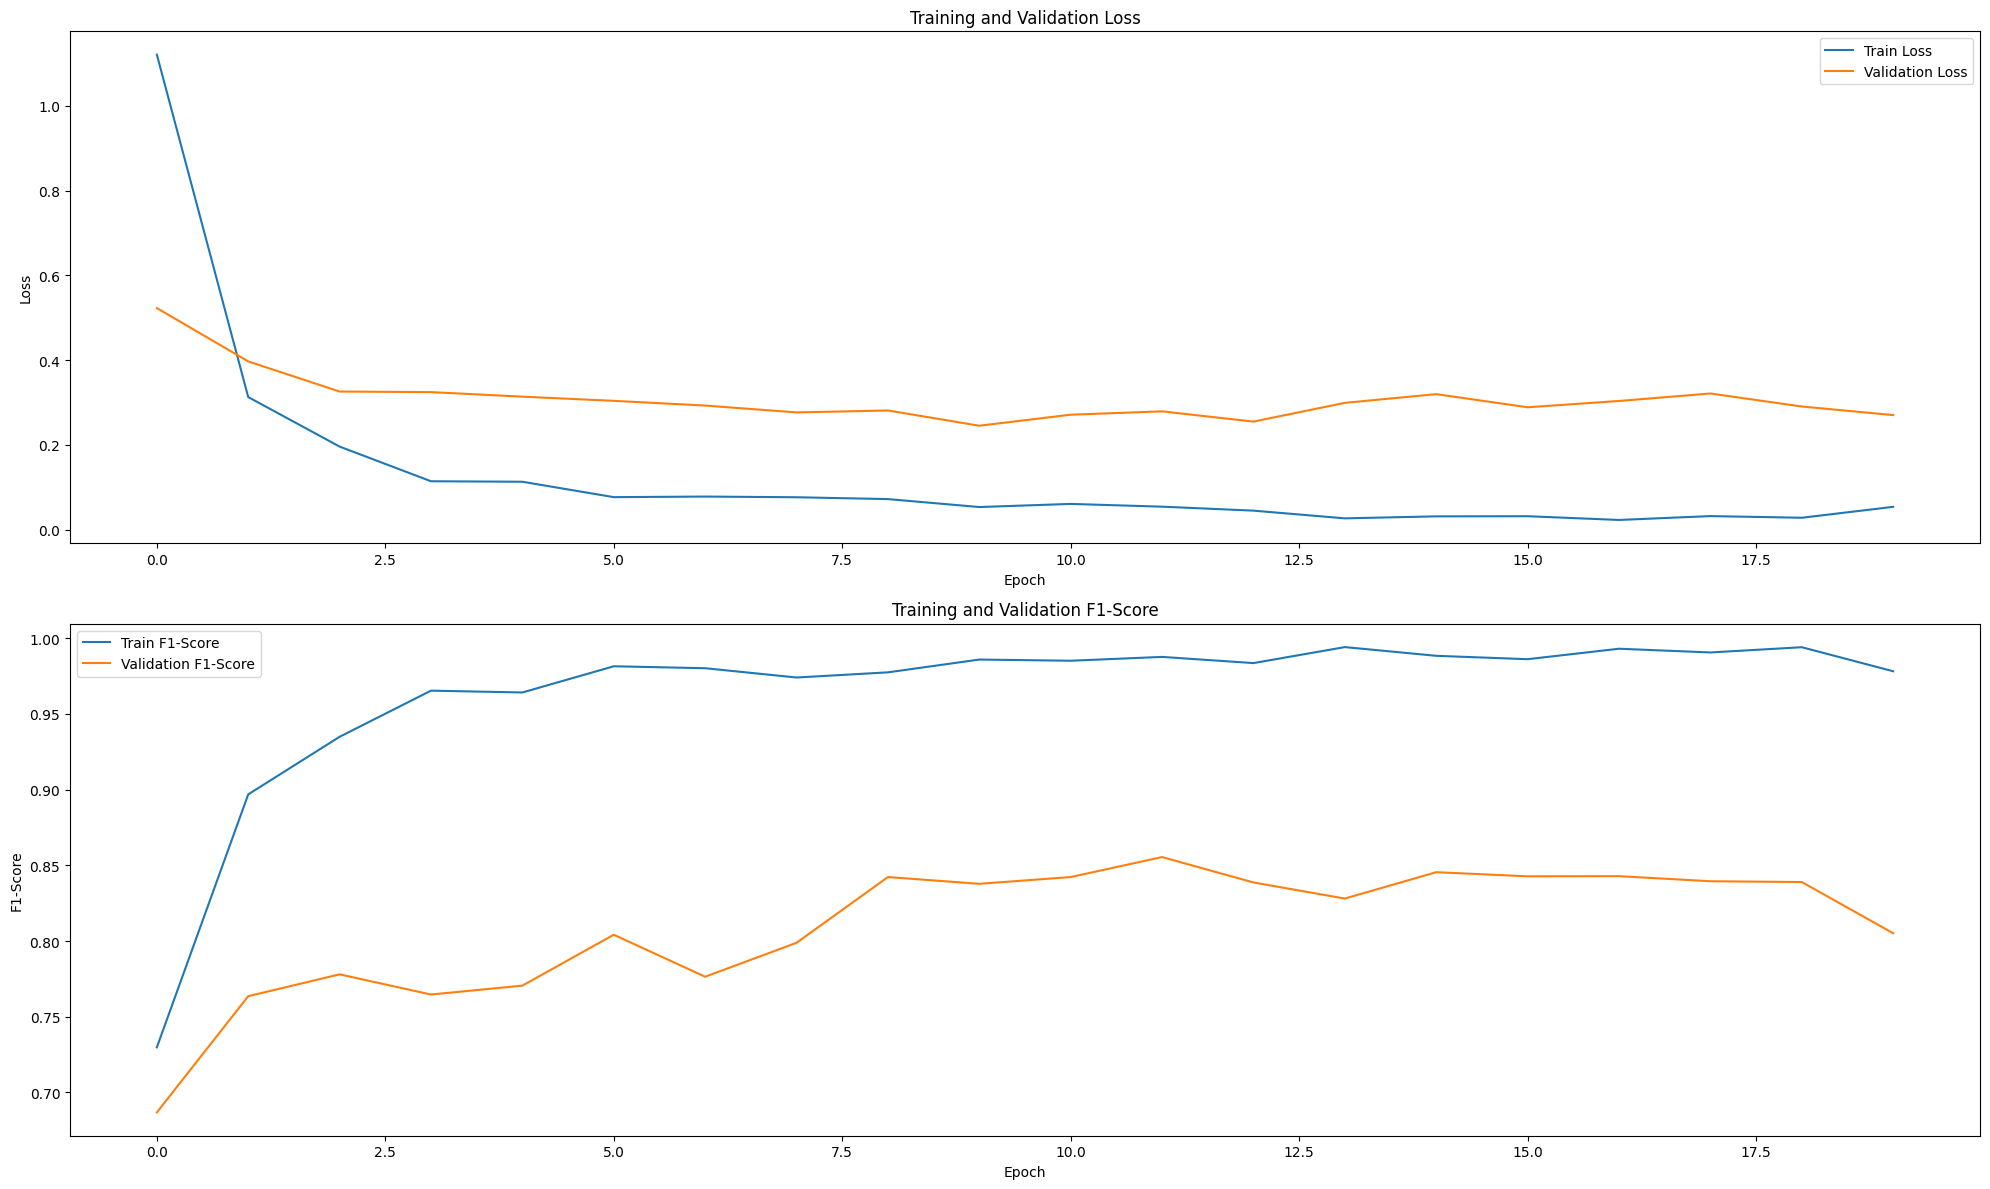

In [ ]:
plot_training_results(history=history_5)

In [ ]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model_ef_v2, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.9045, Precision: 0.7778, Recall: 0.8173, F1 Score: 0.7926
Classification Report : 

              precision    recall  f1-score   support

           0       0.94      0.91      0.93        34
           1       0.91      0.93      0.92        42
           2       0.98      0.93      0.96        58
           3       0.67      0.67      0.67         3
           4       0.75      0.60      0.67         5
           5       0.78      1.00      0.88         7
           6       0.60      0.75      0.67         4
           7       0.60      0.75      0.67         4

    accuracy                           0.90       157
   macro avg       0.78      0.82      0.79       157
weighted avg       0.91      0.90      0.91       157



### **2.8. Efficient Net B7**

In [ ]:
# Efficient Net B7
config_ef_B7 = dict(
    resize = 600,
    crop = 600,
    augment= False,
    epochs =10,
    batch_size = 32,
    lr = 0.001,
    dropout = 0.2,
    weights_path = 'weights_basic_efB7_2.pth'
)

#### **A. Create Data Loader**

In [ ]:
# Get transformations
train_transform = get_transforms(config=config_ef_B7, augment=config_ef_B7['augment'])
val_test_transform = get_transforms(config=config_ef_B7, augment=False)
# dataset
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config_ef_B7['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation',resize=config_ef_B7['resize'], transform=val_test_transform)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test',resize=config_ef_B7['resize'], transform=val_test_transform )
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=config_ef_B7['batch_size'], shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=config_ef_B7['batch_size'], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config_ef_B7['batch_size'], shuffle=False, num_workers=4)

#### **B. Balancing classes**

In [ ]:
# Assign Weights to Each Sample
sample_weights = [class_weights[label] for _, label in train_loader.dataset] # The class weights are calculated in: 2.2.ResNet 18

# Convert list of sample weights to a Torch tensor
sample_weights = torch.tensor(sample_weights)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Dataloaders setup
train_loader_balanced = DataLoader(train_dataset, batch_size=config_ef_B7['batch_size'], sampler=sampler, num_workers=4)

KeyboardInterrupt: 

In [ ]:
# Initialize a dictionary to count occurrences of each class
num_classes = len(class_weights)  # Ensure class_weights is accessible here
class_count = {i: 0 for i in range(num_classes)}

# Iterate through batches and count after balancing classes
for data, labels in train_loader_balanced:
    for label in labels:
        class_count[label.item()] += 1

# Print class frequencies
print("Class frequencies after balancing:")
for class_id, count in class_count.items():
    print(f"Class {class_id}: {count}")

In [ ]:
# Fetch the first batch of images and labels from the train_loader
for images, labels in train_loader_balanced:
    break

# Print the labels
print('Labels:', labels)

# Make the grid with 2 rows and 8 columns
im = make_grid(images, nrow=2)  # nrow changed to 8 for 2x8 grid

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Increase the figure size
plt.figure(figsize=(40, 30))  # increased figure size

# Display the images grid
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))
plt.axis('off')  # Turn off axis labels
plt.show()

#### **C. Model Training**

In [ ]:
es = EarlyStopping(patience=7, min_delta=0.01, restore_best_weights=False)

In [ ]:
model_ef_B7 = models.efficientnet_b7(weights='DEFAULT', progress=True)
num_ftrs = model_ef_B7.classifier[1].in_features
# Freeze the pre-trained model parameters
for param in model_ef_B7.parameters():
    param.requires_grad = False
model_ef_B7.classifier = nn.Sequential(
                nn.Dropout(p=config_ef_B7["dropout"], inplace=True),
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(),
                nn.Dropout(p=config_ef_B7["dropout"]),
                nn.Linear(1024, num_classes)
            )
model_ef_B7 = model_ef_B7.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:02<00:00, 116MB/s]


In [ ]:
optimizer_ef_B7 = optim.Adam(params=model_ef_B7.parameters(), lr=config_ef_B7['lr'])
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# define optimizer and loss funtion
optimizer_ef_B7 = optim.AdamW(params=model_ef_B7.parameters(), lr=config_ef_B7['lr'])
loss_fn = nn.CrossEntropyLoss()
history_8  = training_pipeline_2(config=config_ef_B7,
                  model = model_ef_B7,
                  train_loader=train_loader_balanced,
                  valid_loader=valid_loader,
                  optimizer=optimizer_ef_B7,
                  loss_fn=loss_fn,
                  early_stopping=None,
                  device=device)

Training Epochs:   0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1/45
----------
Train - Loss: 0.1377, Accuracy: 0.9592, Precision: 0.9594, Recall: 0.9590, F1 Score: 0.9592
Validation - Loss: 0.2996, Accuracy: 0.8921, Precision: 0.7805, Recall: 0.8564, F1 Score: 0.7403

Epoch 2/45
----------
Train - Loss: 0.1425, Accuracy: 0.9574, Precision: 0.9555, Recall: 0.9544, F1 Score: 0.9548
Validation - Loss: 0.2293, Accuracy: 0.9281, Precision: 0.7503, Recall: 0.8796, F1 Score: 0.7879

Epoch 3/45
----------
Train - Loss: 0.0826, Accuracy: 0.9698, Precision: 0.9698, Recall: 0.9695, F1 Score: 0.9693
Validation - Loss: 0.1904, Accuracy: 0.9424, Precision: 0.8678, Recall: 0.8294, F1 Score: 0.7987

Epoch 4/45
----------
Train - Loss: 0.0832, Accuracy: 0.9689, Precision: 0.9709, Recall: 0.9707, F1 Score: 0.9707
Validation - Loss: 0.2796, Accuracy: 0.8921, Precision: 0.8312, Recall: 0.7993, F1 Score: 0.7483

Epoch 5/45
----------
Train - Loss: 0.0865, Accuracy: 0.9654, Precision: 0.9647, Recall: 0.9644, F1 Score: 0.9644
Validation - Loss: 0.2299, Accuracy: 0

In [ ]:
# Define a range of lr values to test
lr_rates = [0.1, 0.05, 0.01, 0.001, 0.0001]

# Initialize a dictionary to store the F1 scores for each lr rate
lr_f1_scores = {}

for lr in lr_rates:
    # Update the dropout in the config
    config_ef_B7['lr'] = lr

    # Reinitialize the model with the new dropout rate
    model_ef_B7.classifier = nn.Sequential(
        nn.Dropout(p=config_ef_B7['dropout'], inplace=True),
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(p=config_ef_B7['dropout']),
        nn.Linear(256, num_classes)
    )
    model_ef_B7 = model_ef_B7.to(device)

    # Reinitialize the optimizer
    optimizer_ef_B7 = optim.Adam(params=model_ef_B7.parameters(), lr=lr)

    # Reinitialize early stopping
    es = EarlyStopping(patience=7, min_delta=0.01, restore_best_weights=False)

    # Train the model
    history = training_pipeline_2(config=config_ef_B7,
                                model=model_ef_B7,
                                train_loader=train_loader_balanced,
                                valid_loader=valid_loader,
                                optimizer=optimizer_ef_B7,
                                loss_fn=loss_fn,
                                early_stopping=es,
                                device=device)

    # Store the best F1 score from the validation phase
    best_f1 = max(history['val_f1'])
    lr_f1_scores[lr] = best_f1
    print(f"Learning Rate: {lr}, Best Validation F1: {best_f1}")

# Identify the best dropout rate
best_dropout = max(lr_f1_scores, key=lr_f1_scores.get)
print(f"Best Dropout Rate: {best_dropout} with F1 Score: {lr_f1_scores[best_dropout]}")


Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train - Loss: 15.7032, Accuracy: 0.6868, Precision: 0.6845, Recall: 0.6848, F1 Score: 0.6840
Validation - Loss: 129.1849, Accuracy: 0.4676, Precision: 0.4354, Recall: 0.4240, F1 Score: 0.3787


Epoch 2/10
----------
Train - Loss: 16.7821, Accuracy: 0.8571, Precision: 0.8574, Recall: 0.8598, F1 Score: 0.8584
Validation - Loss: 65.8402, Accuracy: 0.6475, Precision: 0.5796, Recall: 0.5308, F1 Score: 0.5292
Improvement found, counter reset to 0

Epoch 3/10
----------
Train - Loss: 16.4858, Accuracy: 0.8820, Precision: 0.8822, Recall: 0.8845, F1 Score: 0.8832
Validation - Loss: 52.6384, Accuracy: 0.8129, Precision: 0.6627, Recall: 0.7516, F1 Score: 0.6733
Improvement found, counter reset to 0

Epoch 4/10
----------
Train - Loss: 19.4476, Accuracy: 0.8917, Precision: 0.8891, Recall: 0.8906, F1 Score: 0.8897
Validation - Loss: 36.9793, Accuracy: 0.8921, Precision: 0.8152, Recall: 0.8646, F1 Score: 0.7917
Improvement found, counter reset to 0

Epoch 5/10
----------
Train 

Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train - Loss: 3.6143, Accuracy: 0.7320, Precision: 0.7293, Recall: 0.7272, F1 Score: 0.7280
Validation - Loss: 5.1742, Accuracy: 0.8345, Precision: 0.7577, Recall: 0.7706, F1 Score: 0.7136


Epoch 2/10
----------
Train - Loss: 3.1907, Accuracy: 0.8784, Precision: 0.8792, Recall: 0.8809, F1 Score: 0.8797
Validation - Loss: 4.2169, Accuracy: 0.8921, Precision: 0.7988, Recall: 0.8005, F1 Score: 0.7555
Improvement found, counter reset to 0

Epoch 3/10
----------
Train - Loss: 4.5847, Accuracy: 0.9033, Precision: 0.9051, Recall: 0.9056, F1 Score: 0.9053
Validation - Loss: 7.1155, Accuracy: 0.8633, Precision: 0.6443, Recall: 0.7234, F1 Score: 0.6568
No improvement in the last 1 epochs

Epoch 4/10
----------
Train - Loss: 6.3450, Accuracy: 0.9051, Precision: 0.9071, Recall: 0.9072, F1 Score: 0.9067
Validation - Loss: 8.5450, Accuracy: 0.9137, Precision: 0.6979, Recall: 0.7266, F1 Score: 0.6850
No improvement in the last 2 epochs

Epoch 5/10
----------
Train - Loss: 6.952

Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train - Loss: 0.5147, Accuracy: 0.8474, Precision: 0.8489, Recall: 0.8503, F1 Score: 0.8485
Validation - Loss: 0.7117, Accuracy: 0.8273, Precision: 0.7231, Recall: 0.7311, F1 Score: 0.6714


Epoch 2/10
----------
Train - Loss: 0.2567, Accuracy: 0.9317, Precision: 0.9313, Recall: 0.9313, F1 Score: 0.9311
Validation - Loss: 0.2364, Accuracy: 0.9281, Precision: 0.8956, Recall: 0.8217, F1 Score: 0.8456
Improvement found, counter reset to 0

Epoch 3/10
----------
Train - Loss: 0.4233, Accuracy: 0.9166, Precision: 0.9182, Recall: 0.9173, F1 Score: 0.9176
Validation - Loss: 0.5952, Accuracy: 0.9065, Precision: 0.7032, Recall: 0.7802, F1 Score: 0.7096
No improvement in the last 1 epochs

Epoch 4/10
----------
Train - Loss: 0.2701, Accuracy: 0.9370, Precision: 0.9363, Recall: 0.9353, F1 Score: 0.9357
Validation - Loss: 0.3953, Accuracy: 0.9281, Precision: 0.8155, Recall: 0.8216, F1 Score: 0.7820
No improvement in the last 2 epochs

Epoch 5/10
----------
Train - Loss: 0.156

Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train - Loss: 1.0237, Accuracy: 0.7817, Precision: 0.7913, Recall: 0.7805, F1 Score: 0.7684
Validation - Loss: 0.4600, Accuracy: 0.8345, Precision: 0.6061, Recall: 0.6775, F1 Score: 0.5965


Epoch 2/10
----------
Train - Loss: 0.2767, Accuracy: 0.9264, Precision: 0.9248, Recall: 0.9256, F1 Score: 0.9245
Validation - Loss: 0.2882, Accuracy: 0.9209, Precision: 0.7775, Recall: 0.7636, F1 Score: 0.7223
Improvement found, counter reset to 0

Epoch 3/10
----------
Train - Loss: 0.1571, Accuracy: 0.9636, Precision: 0.9619, Recall: 0.9619, F1 Score: 0.9616
Validation - Loss: 0.2370, Accuracy: 0.9353, Precision: 0.8031, Recall: 0.8249, F1 Score: 0.7702
Improvement found, counter reset to 0

Epoch 4/10
----------
Train - Loss: 0.1219, Accuracy: 0.9654, Precision: 0.9655, Recall: 0.9649, F1 Score: 0.9649
Validation - Loss: 0.2213, Accuracy: 0.9353, Precision: 0.8000, Recall: 0.8261, F1 Score: 0.7650
Improvement found, counter reset to 0

Epoch 5/10
----------
Train - Loss: 0

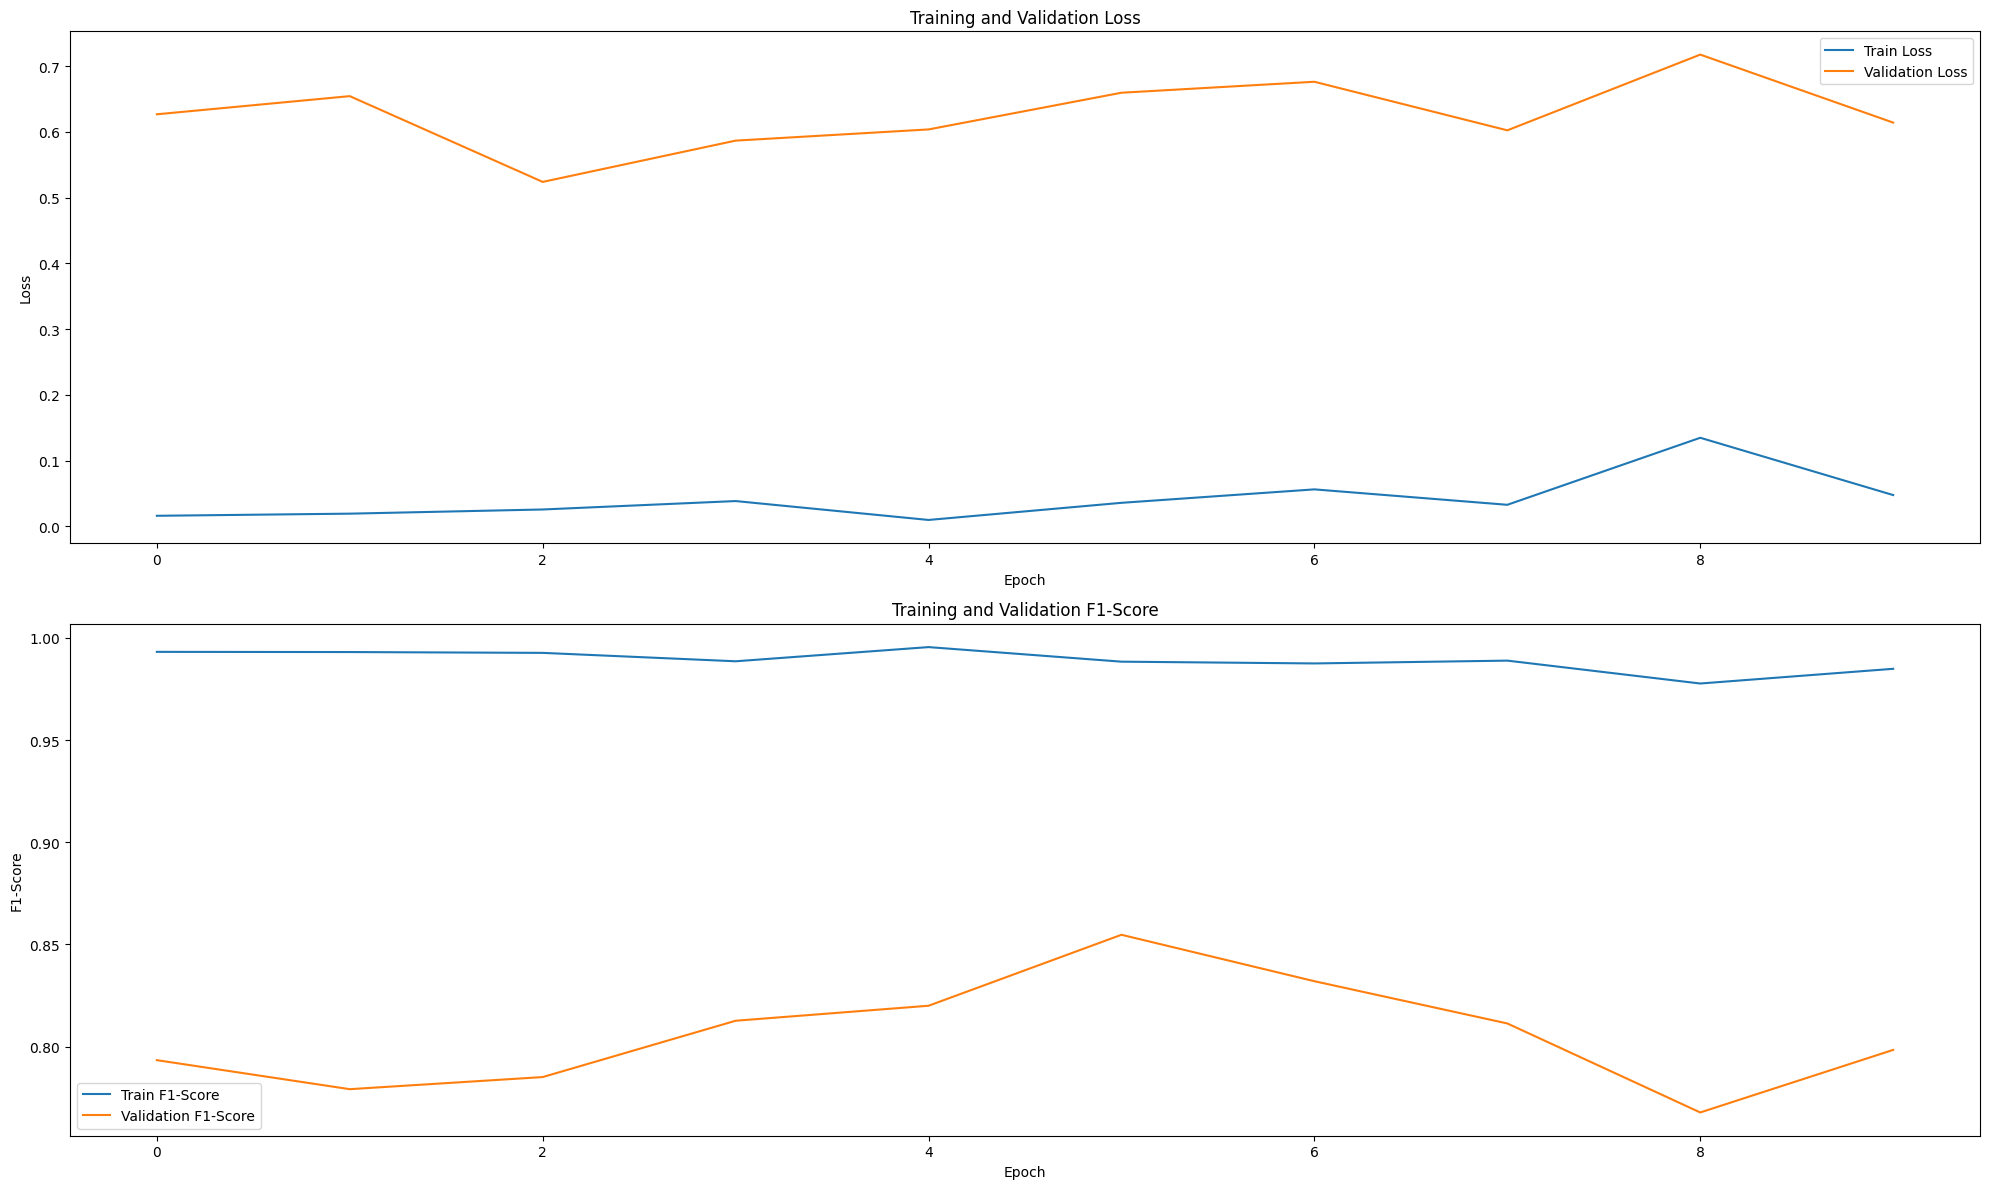

In [ ]:
plot_training_results(history=history_8)

In [ ]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model_ef_B7, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.9236, Precision: 0.9251, Recall: 0.8992, F1 Score: 0.9097
Classification Report : 

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        34
           1       0.86      0.90      0.88        42
           2       0.98      0.93      0.96        58
           3       0.67      0.67      0.67         3
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         7
           6       1.00      0.75      0.86         4
           7       1.00      1.00      1.00         4

    accuracy                           0.92       157
   macro avg       0.93      0.90      0.91       157
weighted avg       0.93      0.92      0.92       157



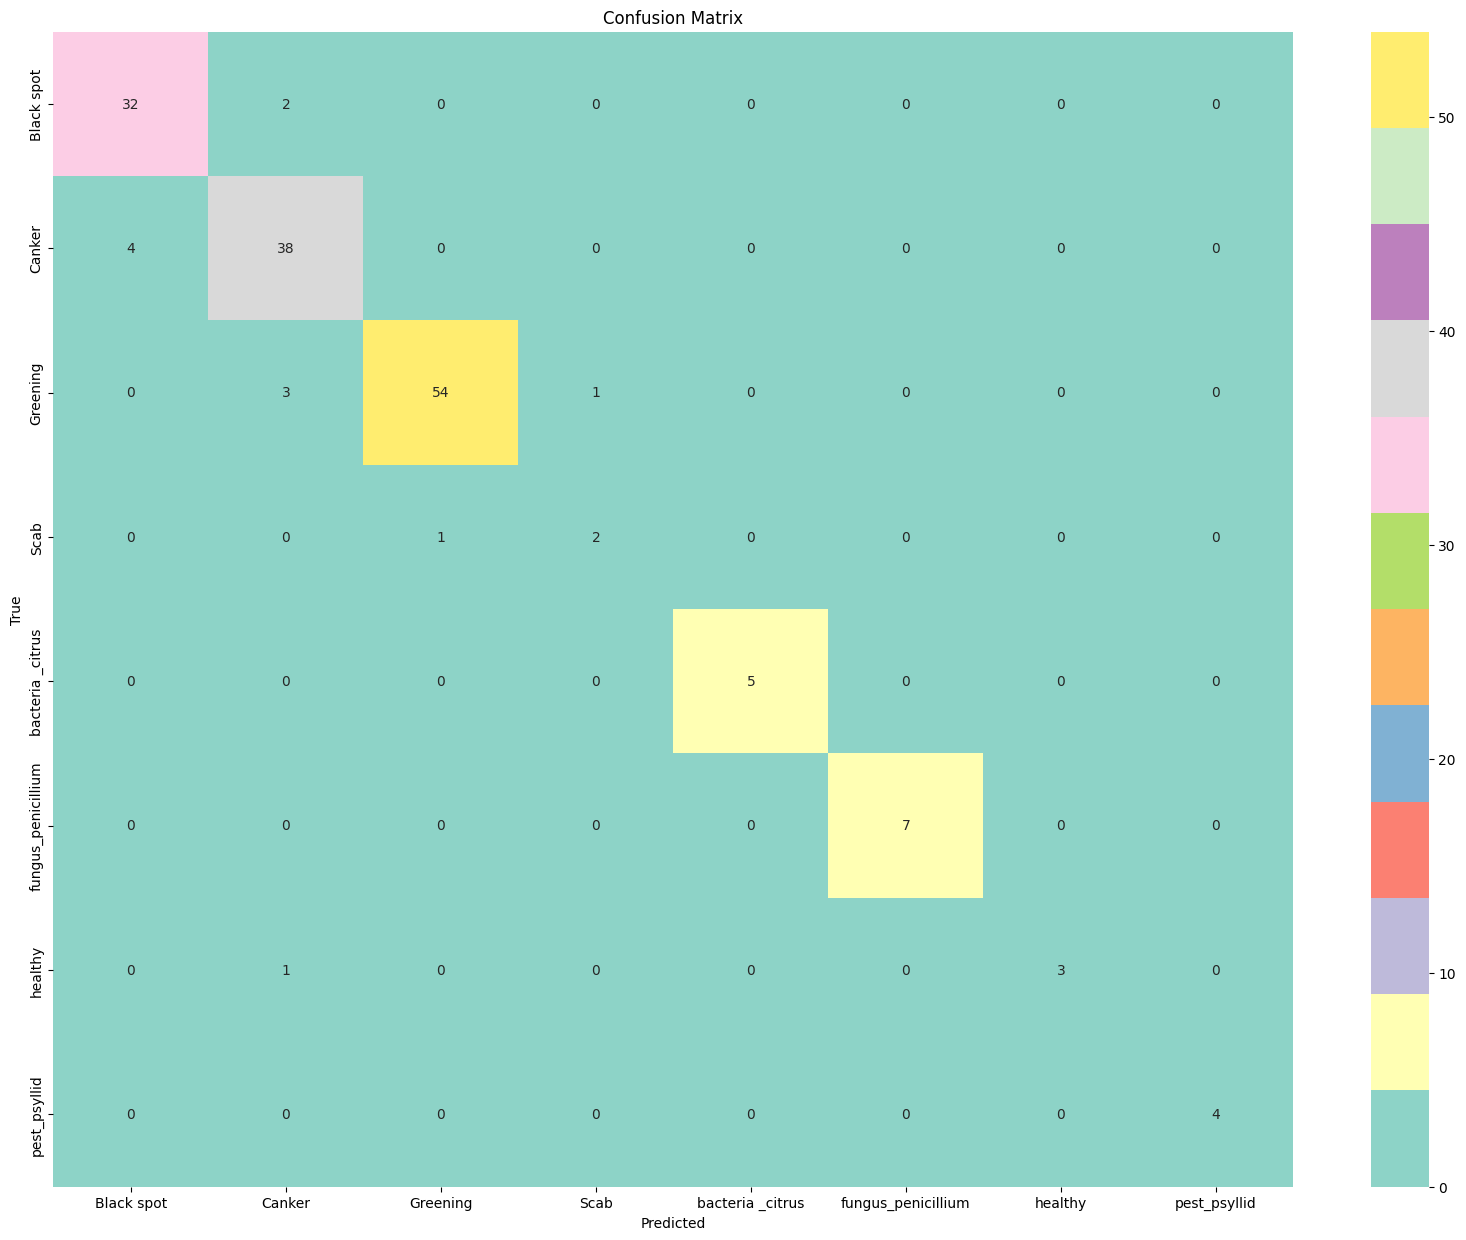

In [ ]:
# plot confusion matrix
plot_cm(cm, classes, title="Confusion Matrix")

## **3. Model Training with Augmentation**

### **3.1. ResNet-18**

In [ ]:
# tweak these and experiment with different values.
config_resnet_aug = dict(
    resize =1365,
    crop = 1024,
    augment= True,
    epochs = 50,
    batch_size = 32,
    lr = 0.001,
    dropout = 0.2,
    weights_path = 'weights_augmented_resnet_18.pth'
)

In [ ]:
# Get transformations
train_transform = get_transforms(config=config_resnet_aug, augment=config_resnet_aug['augment'])
val_test_transform = get_transforms(config=config_resnet_aug, augment=False)
# dataset
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config_resnet_aug['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation',resize=config_resnet_aug['resize'], transform=val_test_transform)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test',resize=config_resnet_aug['resize'], transform=val_test_transform )
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)

Labels: tensor([2, 2, 2, 0, 5, 2, 5, 0, 5, 2, 2, 5, 1, 2, 0, 3, 7, 1, 5, 2, 1, 1, 1, 1,
        2, 2, 2, 5, 0, 2, 2, 2])


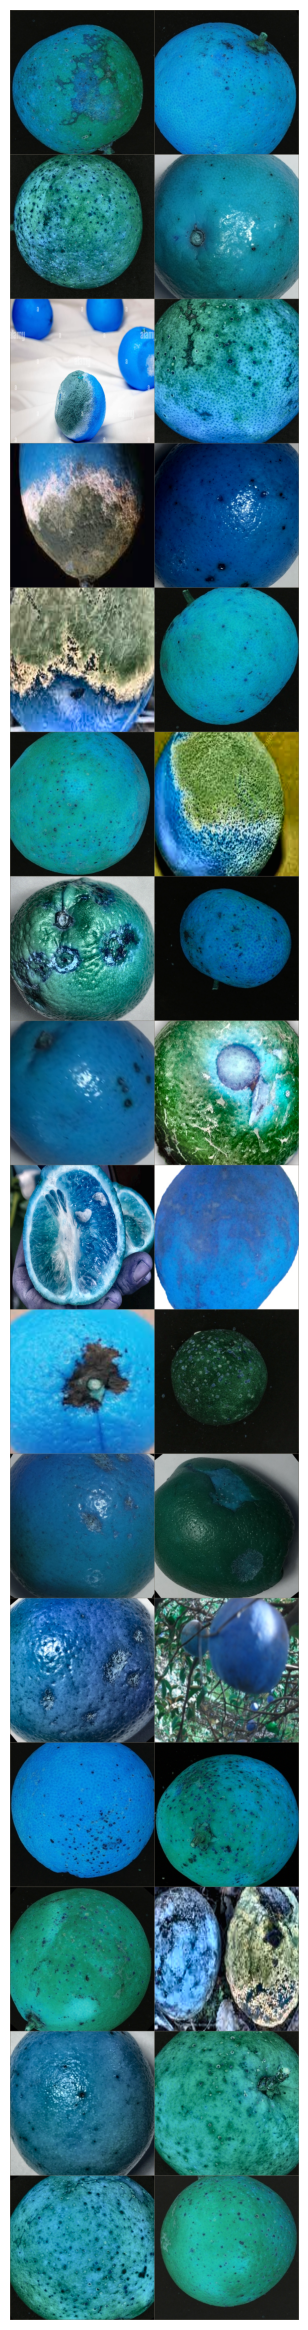

In [ ]:
# Fetch the first batch of images and labels from the train_loader
for images, labels in train_loader:
    break

# Print the labels
print('Labels:', labels)

# Make the grid with 2 rows and 8 columns
im = make_grid(images, nrow=2)  # nrow changed to 8 for 2x8 grid

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Increase the figure size
plt.figure(figsize=(40, 30))  # increased figure size

# Display the images grid
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
es = EarlyStopping(patience=5, min_delta=0.01, restore_best_weights=False)

In [ ]:
# initialise pre-trained weights
weights = models.ResNet18_Weights.IMAGENET1K_V1
# initialize the model
resnet18 = models.resnet18(weights='IMAGENET1K_V1', progress=True)
# Freeze the pre-trained model parameters
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the last fully connected layer
resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, 1024),
    nn.ReLU(),
    nn.Dropout(config['dropout']),
    nn.Linear(in_features=1024, out_features= num_classes),
    nn.Softmax(dim=1)
)

# Move the model to the specified device
resnet18 = resnet18.to(device)

In [ ]:
# define optimizer and loss funtion
optimizer_resnet = optim.Adam(params=resnet18.parameters(), lr=config['lr'])
loss_fn = nn.CrossEntropyLoss()

In [ ]:
history_3  = training_pipeline(config=config_resnet_aug,
                  model = resnet18,
                  train_loader=train_loader,
                  valid_loader=valid_loader,
                  optimizer=optimizer_resnet,
                  loss_fn=loss_fn,
                  early_stopping=None,
                  device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
----------
Train - Loss: 1.7347, Accuracy: 0.5435, Precision: 0.1763, Recall: 0.2088, F1 Score: 0.1777
Validation - Loss: 1.6455, Accuracy: 0.6340, Precision: 0.1786, Recall: 0.2435, F1 Score: 0.1967

Epoch 2/50
----------
Train - Loss: 1.6644, Accuracy: 0.6081, Precision: 0.1615, Recall: 0.2331, F1 Score: 0.1858
Validation - Loss: 1.6297, Accuracy: 0.6471, Precision: 0.1797, Recall: 0.2478, F1 Score: 0.2000

Epoch 3/50
----------
Train - Loss: 1.6423, Accuracy: 0.6348, Precision: 0.1755, Recall: 0.2441, F1 Score: 0.1962
Validation - Loss: 1.6326, Accuracy: 0.6405, Precision: 0.1753, Recall: 0.2449, F1 Score: 0.1972

Epoch 4/50
----------
Train - Loss: 1.6417, Accuracy: 0.6348, Precision: 0.1748, Recall: 0.2441, F1 Score: 0.1960
Validation - Loss: 1.6342, Accuracy: 0.6405, Precision: 0.1753, Recall: 0.2449, F1 Score: 0.1972

Epoch 5/50
----------
Train - Loss: 1.6431, Accuracy: 0.6306, Precision: 0.1733, Recall: 0.2421, F1 Score: 0.1946
Validation - Loss: 1.6314, Accuracy: 0

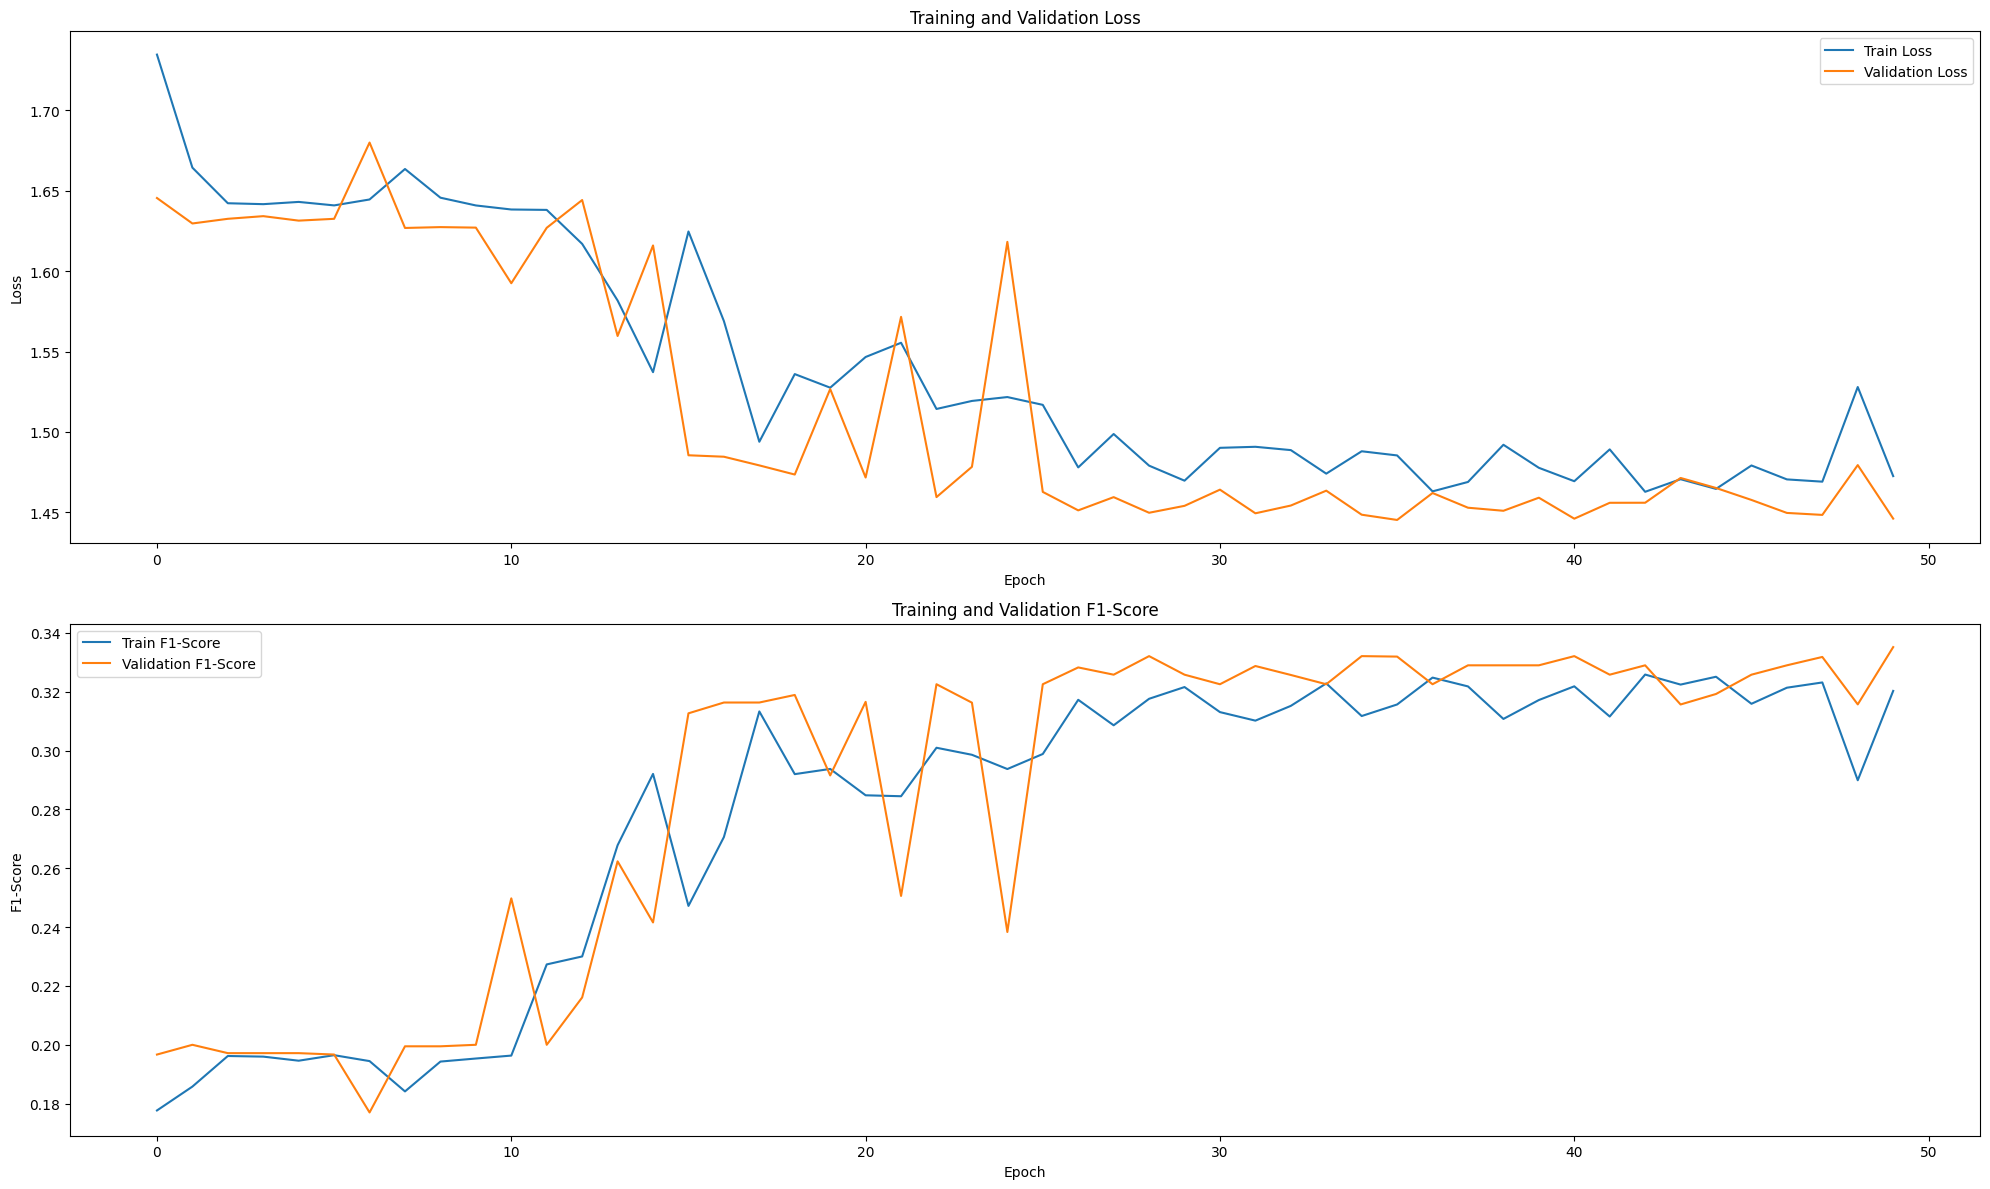

In [ ]:
plot_training_results(history=history_3)

In [ ]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=resnet18, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.7898, Precision: 0.3054, Recall: 0.3479, F1 Score: 0.3218
Classification Report : 

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        34
           1       0.59      0.93      0.72        42
           2       0.96      0.91      0.94        58
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4

    accuracy                           0.79       157
   macro avg       0.31      0.35      0.32       157
weighted avg       0.71      0.79      0.74       157



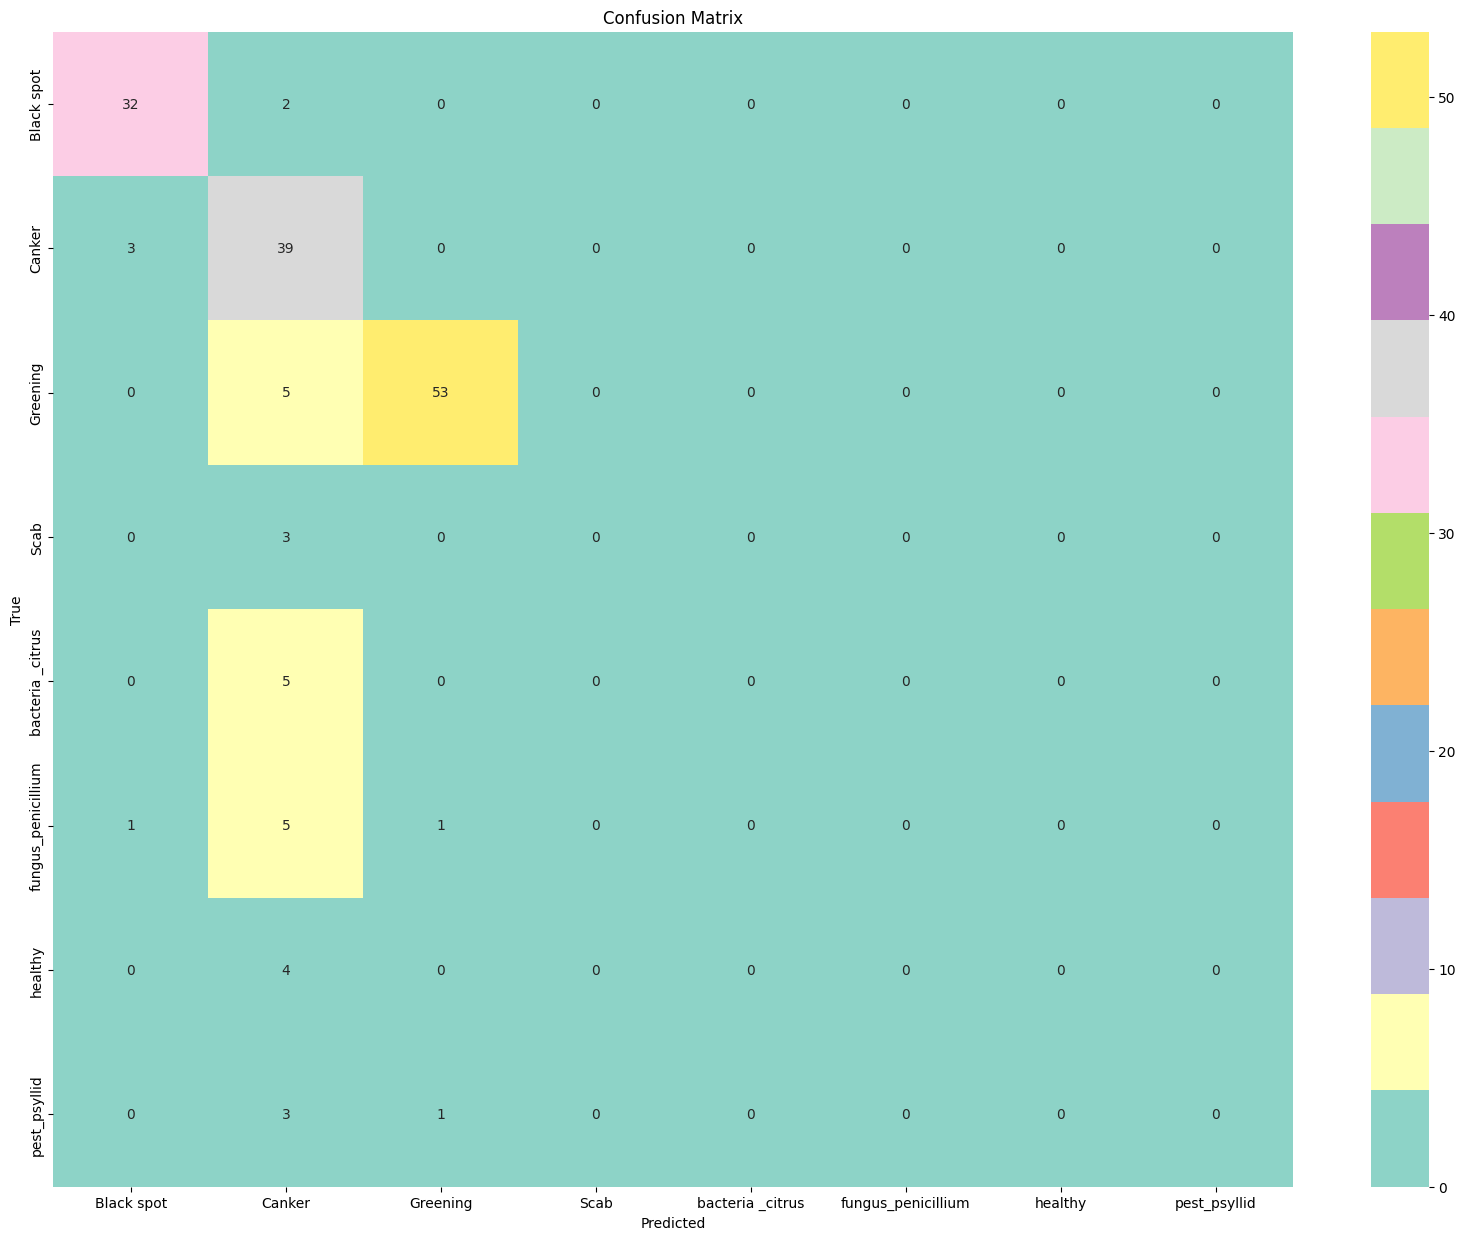

In [ ]:
# plot confusion matrix
plot_cm(cm, classes, title="Confusion Matrix")

### **3.3. Efficient Net B1 [2]**

In [ ]:
# Efficient Net B1 v2
config_ef_aug_v2 = dict(
    resize =256,
    crop = 240,
    augment= True,
    epochs = 30,
    batch_size = 32,
    lr = 0.001,
    dropout = 0.2,
    weights_path = 'weights_augmented_EFnet_v2.pth'
)

#### **A. Create Data Loader**

In [ ]:
# Get transformations
train_transform = get_transforms(config=config_ef_aug_v2, augment=config_ef_aug_v2['augment'])
val_test_transform = get_transforms(config=config_ef_aug_v2, augment=False)
# dataset
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config_ef_aug_v2['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation',resize=config_ef_aug_v2['resize'], transform=val_test_transform)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test',resize=config_ef_aug_v2['resize'], transform=val_test_transform )
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=config_ef_aug_v2['batch_size'], shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=config_ef_aug_v2['batch_size'], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config_ef_aug_v2['batch_size'], shuffle=False, num_workers=4)

#### **B. Balancing classes**

In [ ]:
# Assign Weights to Each Sample
sample_weights = [class_weights[label] for _, label in train_loader.dataset] # The class weights are calculated in: 2.2.ResNet 18

# Convert list of sample weights to a Torch tensor
sample_weights = torch.tensor(sample_weights)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Dataloaders setup
train_loader_balanced = DataLoader(train_dataset, batch_size=config_ef_aug_v2['batch_size'], sampler=sampler, num_workers=4)

In [ ]:
# Initialize a dictionary to count occurrences of each class
num_classes = len(class_weights)  # Ensure class_weights is accessible here
class_count = {i: 0 for i in range(num_classes)}

# Iterate through batches and count after balancing classes
for data, labels in train_loader_balanced:
    for label in labels:
        class_count[label.item()] += 1

# Print class frequencies
print("Class frequencies after balancing:")
for class_id, count in class_count.items():
    print(f"Class {class_id}: {count}")

Class frequencies after balancing:
Class 0: 87
Class 1: 87
Class 2: 73
Class 3: 97
Class 4: 82
Class 5: 100
Class 6: 95
Class 7: 91


Labels: tensor([1, 6, 5, 0, 6, 2, 2, 2, 5, 0, 3, 3, 3, 5, 3, 1, 0, 6, 1, 2, 5, 5, 6, 7,
        7, 2, 1, 5, 2, 5, 7, 4])


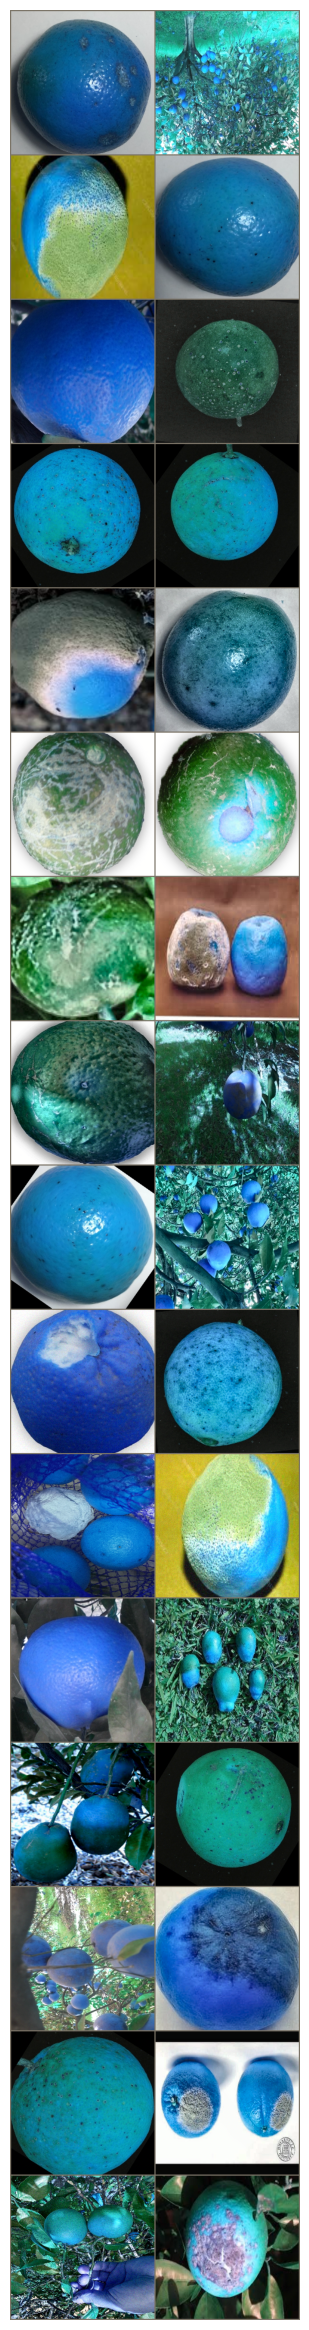

In [ ]:
# Fetch the first batch of images and labels from the train_loader
for images, labels in train_loader_balanced:
    break

# Print the labels
print('Labels:', labels)

# Make the grid with 2 rows and 8 columns
im = make_grid(images, nrow=2)  # nrow changed to 8 for 2x8 grid

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Increase the figure size
plt.figure(figsize=(40, 30))  # increased figure size

# Display the images grid
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))
plt.axis('off')  # Turn off axis labels
plt.show()

#### **C. Training**

In [ ]:
es = EarlyStopping(patience=10, min_delta=0.01, restore_best_weights=False)

In [ ]:
model_ef_aug_v2 = models.efficientnet_b1(weights='DEFAULT', progress=True)
num_ftrs = model_ef_aug_v2.classifier[1].in_features
# Freeze the pre-trained model parameters
for param in model_ef_aug_v2.parameters():
    param.requires_grad = False
model_ef_aug_v2.classifier = nn.Sequential(
                nn.Dropout(p=config_ef_aug_v2["dropout"], inplace=True),
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(),
                nn.Dropout(p=config_ef_aug_v2["dropout"]),
                nn.Linear(1024, num_classes)
            )
model_ef_aug_v2 = model_ef_aug_v2.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 68.6MB/s]


In [ ]:
# define optimizer and loss funtion
optimizer_ef_aug_v2 = optim.Adam(params=model_ef_aug_v2.parameters(), lr=config_ef_aug_v2['lr'])
loss_fn = nn.CrossEntropyLoss()

In [ ]:
history_6  = training_pipeline(config=config_ef_aug_v2,
                  model = model_ef_aug_v2,
                  train_loader=train_loader_balanced,
                  valid_loader=valid_loader,
                  optimizer=optimizer_ef_aug_v2,
                  loss_fn=loss_fn,
                  early_stopping=None,
                  device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
----------
Train - Loss: 0.0527, Accuracy: 0.9803, Precision: 0.9789, Recall: 0.9802, F1 Score: 0.9794
Validation - Loss: 0.2652, Accuracy: 0.9150, Precision: 0.8063, Recall: 0.8560, F1 Score: 0.8210

Epoch 2/30
----------
Train - Loss: 0.0830, Accuracy: 0.9761, Precision: 0.9771, Recall: 0.9777, F1 Score: 0.9773
Validation - Loss: 0.2650, Accuracy: 0.9150, Precision: 0.8205, Recall: 0.8551, F1 Score: 0.8320

Epoch 3/30
----------
Train - Loss: 0.0843, Accuracy: 0.9649, Precision: 0.9663, Recall: 0.9666, F1 Score: 0.9664
Validation - Loss: 0.2581, Accuracy: 0.9085, Precision: 0.8241, Recall: 0.8537, F1 Score: 0.8332

Epoch 4/30
----------
Train - Loss: 0.0588, Accuracy: 0.9860, Precision: 0.9858, Recall: 0.9850, F1 Score: 0.9853
Validation - Loss: 0.2758, Accuracy: 0.9216, Precision: 0.8684, Recall: 0.8610, F1 Score: 0.8501

Epoch 5/30
----------
Train - Loss: 0.0587, Accuracy: 0.9817, Precision: 0.9827, Recall: 0.9822, F1 Score: 0.9823
Validation - Loss: 0.2873, Accuracy: 0

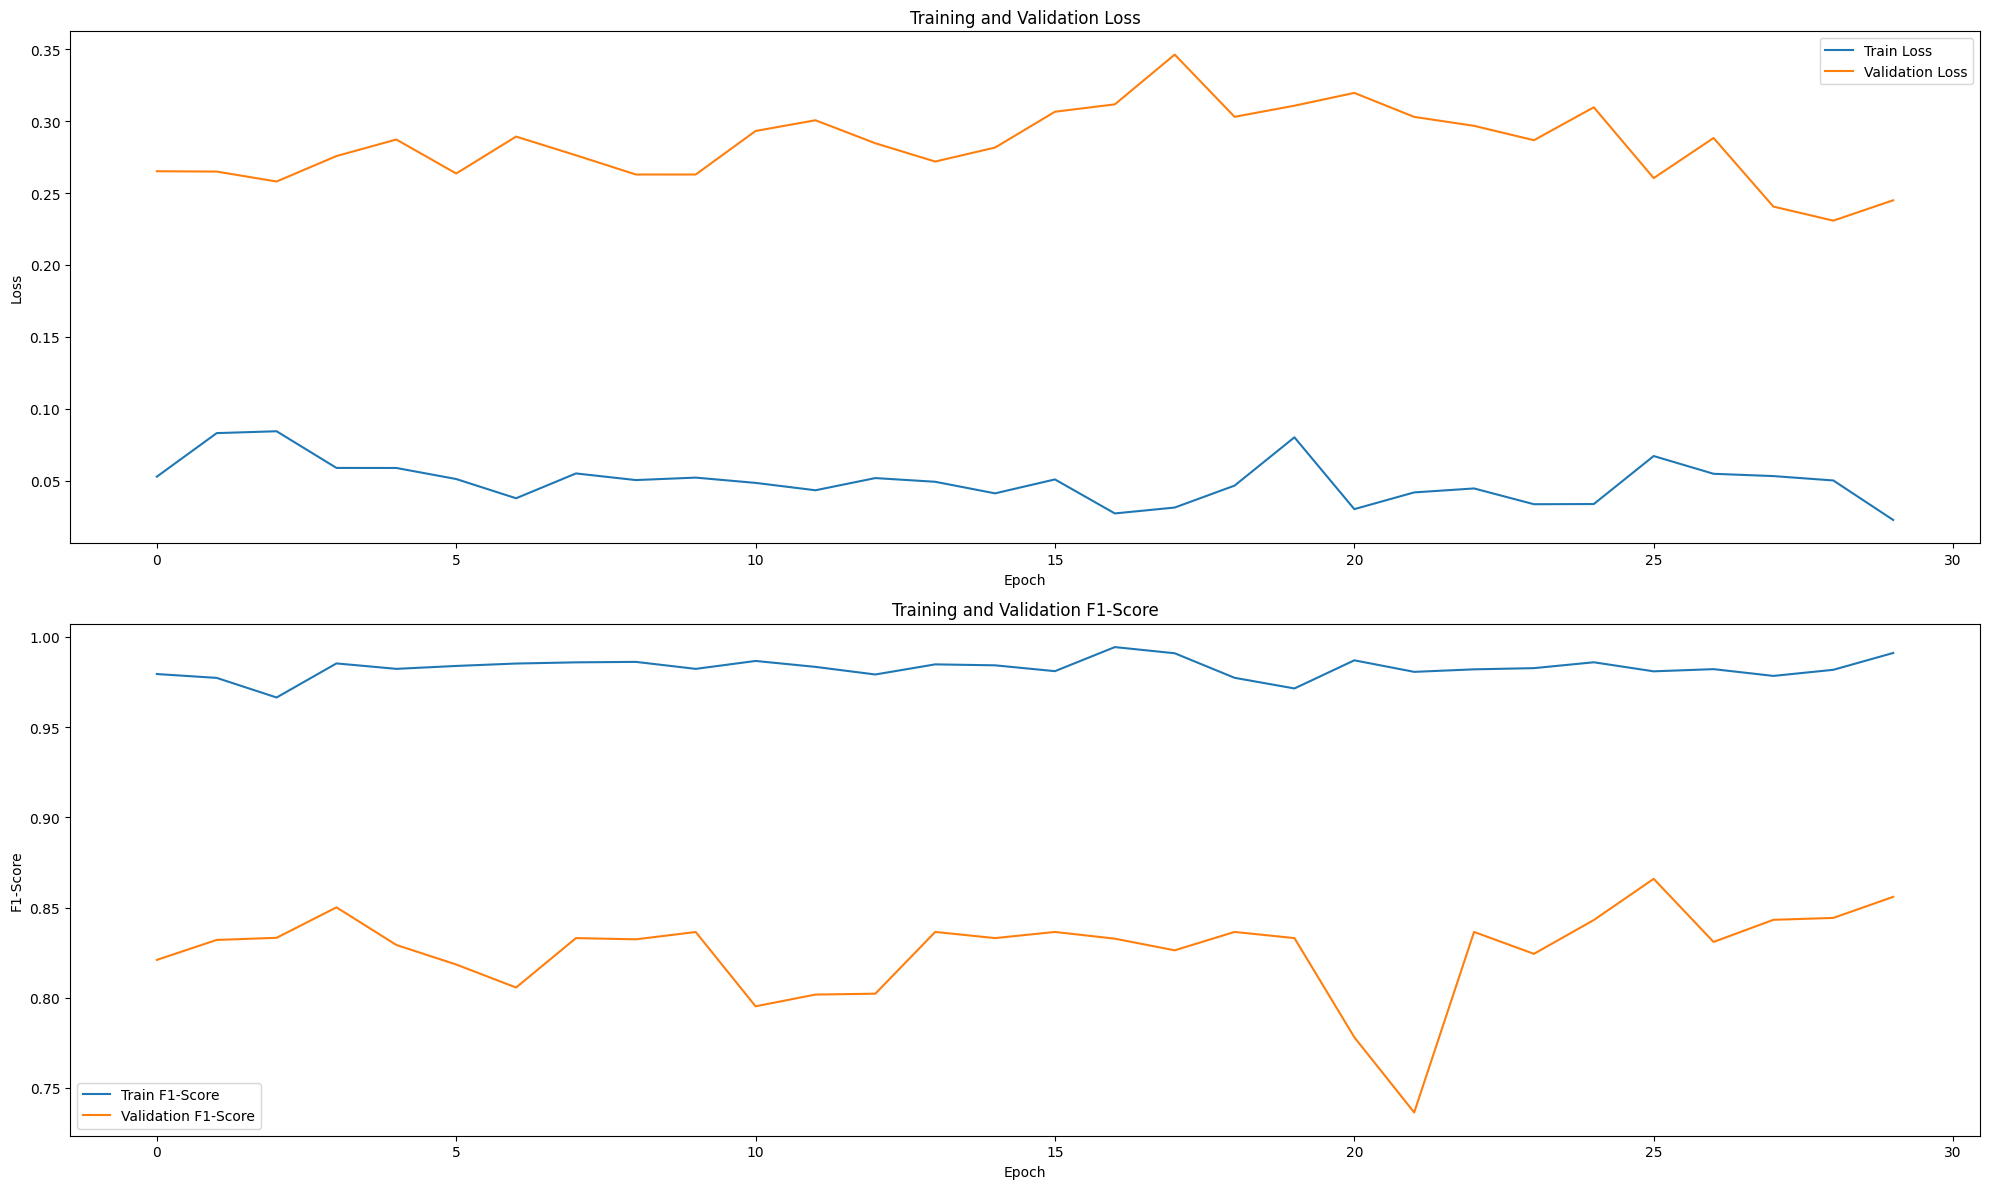

In [ ]:
plot_training_results(history=history_6)

In [ ]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model_ef_aug_v2, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.9045, Precision: 0.8299, Recall: 0.8753, F1 Score: 0.8358
Classification Report : 

              precision    recall  f1-score   support

           0       0.86      0.94      0.90        34
           1       0.95      0.88      0.91        42
           2       0.98      0.91      0.95        58
           3       0.40      0.67      0.50         3
           4       1.00      0.60      0.75         5
           5       0.78      1.00      0.88         7
           6       1.00      1.00      1.00         4
           7       0.67      1.00      0.80         4

    accuracy                           0.90       157
   macro avg       0.83      0.88      0.84       157
weighted avg       0.92      0.90      0.91       157



### **3.3. Efficient B7**

In [ ]:
# Efficient Net B7
config_ef_B7_aug = dict(
    resize = 600,
    crop = 600,
    augment= True,
    epochs = 10,
    batch_size = 64,
    lr = 0.0008,
    dropout = 0.2,
    weights_path = 'weights_efB7_aug_2.pth'
)

#### **A. Create Data Loader**

In [ ]:
# Get transformations
train_transform = get_transforms(config=config_ef_B7_aug, augment=config_ef_B7_aug['augment'])
val_test_transform = get_transforms(config=config_ef_B7_aug, augment=False)
# dataset
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config_ef_B7_aug['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation',resize=config_ef_B7_aug['resize'], transform=val_test_transform)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test',resize=config_ef_B7_aug['resize'], transform=val_test_transform )
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=config_ef_B7_aug['batch_size'], shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=config_ef_B7_aug['batch_size'], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config_ef_B7_aug['batch_size'], shuffle=False, num_workers=4)

#### **B. Balancing classes**

In [ ]:
# Assign Weights to Each Sample
sample_weights = [class_weights[label] for _, label in train_loader.dataset] # The class weights are calculated in: 2.2.ResNet 18

# Convert list of sample weights to a Torch tensor
sample_weights = torch.tensor(sample_weights)

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Dataloaders setup
train_loader_balanced = DataLoader(train_dataset, batch_size=config_ef_B7_aug['batch_size'], sampler=sampler, num_workers=4)

In [ ]:
# Initialize a dictionary to count occurrences of each class
num_classes = len(class_weights)  # Ensure class_weights is accessible here
class_count = {i: 0 for i in range(num_classes)}

# Iterate through batches and count after balancing classes
for data, labels in train_loader_balanced:
    for label in labels:
        class_count[label.item()] += 1

# Print class frequencies
print("Class frequencies after balancing:")
for class_id, count in class_count.items():
    print(f"Class {class_id}: {count}")

Class frequencies after balancing:
Class 0: 129
Class 1: 145
Class 2: 155
Class 3: 147
Class 4: 117
Class 5: 151
Class 6: 139
Class 7: 144


Labels: tensor([1, 6, 2, 6, 6, 2, 2, 2, 3, 0, 0, 3, 0, 0, 7, 3, 4, 4, 6, 2, 3, 6, 6, 6,
        4, 1, 1, 2, 0, 0, 7, 3, 6, 1, 0, 0, 2, 1, 7, 7, 5, 4, 2, 6, 2, 3, 7, 4,
        7, 1, 6, 1, 2, 6, 2, 4, 4, 0, 4, 7, 5, 4, 5, 4])


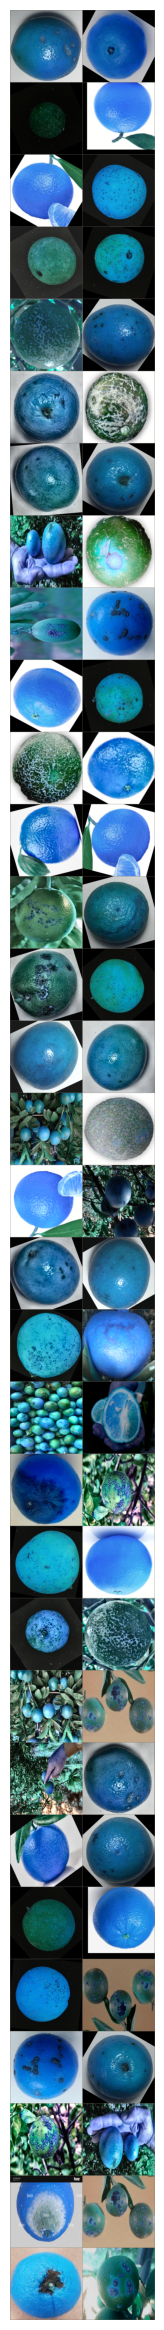

In [ ]:
# Fetch the first batch of images and labels from the train_loader
for images, labels in train_loader_balanced:
    break

# Print the labels
print('Labels:', labels)

# Make the grid with 2 rows and 8 columns
im = make_grid(images, nrow=2)  # nrow changed to 8 for 2x8 grid

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Increase the figure size
plt.figure(figsize=(40, 30))  # increased figure size

# Display the images grid
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))
plt.axis('off')  # Turn off axis labels
plt.show()

#### **C. Model Training**

In [ ]:
es = EarlyStopping(patience=10, min_delta=0.01, restore_best_weights=False)

In [ ]:
model_ef_B7_aug = models.efficientnet_b7(weights='DEFAULT', progress=True)
num_ftrs = model_ef_B7_aug.classifier[1].in_features
# Freeze the pre-trained model parameters
for param in model_ef_B7_aug.parameters():
    param.requires_grad = False
model_ef_B7_aug.classifier = nn.Sequential(
                nn.Dropout(p=config_ef_B7_aug["dropout"], inplace=True),
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(),
                nn.Dropout(p=config_ef_B7_aug["dropout"]),
                nn.Linear(1024, num_classes)
            )
model_ef_B7_aug = model_ef_B7_aug.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:02<00:00, 114MB/s]


In [ ]:
# Path to the saved weights
model_weights_path = '/content/weights_efB7_aug_2 (1).pth'

# Load the weights
model_ef_B7_aug.load_state_dict(torch.load(model_weights_path, map_location=device))


<All keys matched successfully>

In [ ]:
# define optimizer and loss funtion
optimizer_ef_B7_aug = optim.AdamW(params=model_ef_B7_aug.parameters(), lr=config_ef_B7_aug['lr'])
loss_fn = nn.CrossEntropyLoss()
history_9  = training_pipeline_2(config=config_ef_B7_aug,
                  model = model_ef_B7_aug,
                  train_loader=train_loader_balanced,
                  valid_loader=valid_loader,
                  optimizer=optimizer_ef_B7_aug,
                  loss_fn=loss_fn,
                  early_stopping=None,
                  device=device)

Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
Train - Loss: 0.0617, Accuracy: 0.9725, Precision: 0.9730, Recall: 0.9723, F1 Score: 0.9726
Validation - Loss: 0.2648, Accuracy: 0.8993, Precision: 0.7675, Recall: 0.8038, F1 Score: 0.7473

Epoch 2/10
----------
Train - Loss: 0.0536, Accuracy: 0.9787, Precision: 0.9793, Recall: 0.9782, F1 Score: 0.9785
Validation - Loss: 0.3273, Accuracy: 0.9137, Precision: 0.7657, Recall: 0.8127, F1 Score: 0.7533

Epoch 3/10
----------
Train - Loss: 0.0599, Accuracy: 0.9796, Precision: 0.9806, Recall: 0.9797, F1 Score: 0.9799
Validation - Loss: 0.2957, Accuracy: 0.9281, Precision: 0.7896, Recall: 0.8216, F1 Score: 0.7801

Epoch 4/10
----------
Train - Loss: 0.0416, Accuracy: 0.9831, Precision: 0.9838, Recall: 0.9842, F1 Score: 0.9839
Validation - Loss: 0.2923, Accuracy: 0.9281, Precision: 0.7896, Recall: 0.8216, F1 Score: 0.7676

Epoch 5/10
----------
Train - Loss: 0.0374, Accuracy: 0.9849, Precision: 0.9850, Recall: 0.9850, F1 Score: 0.9850
Validation - Loss: 0.3027, Accuracy: 0

In [ ]:
# class frequencies
class_freq_test = test_loader.dataset.get_class_frequencies()
class_freq_test

{0: 23, 1: 28, 2: 39, 3: 2, 4: 3, 5: 5, 6: 41, 7: 3}

In [ ]:
classes = test_dataset.class_names
print(classes)

['Black spot', 'Canker', 'Greening', 'Scab', 'bacteria _citrus', 'fungus_penicillium', 'healthy', 'pest_psyllid']


In [ ]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model_ef_B7_aug, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.9653, Precision: 0.9514, Recall: 0.9408, F1 Score: 0.9397
Classification Report : 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        23
           1       0.93      0.93      0.93        28
           2       1.00      0.97      0.99        39
           3       1.00      1.00      1.00         2
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         5
           6       0.98      1.00      0.99        41
           7       0.75      1.00      0.86         3

    accuracy                           0.97       144
   macro avg       0.95      0.94      0.94       144
weighted avg       0.97      0.97      0.97       144



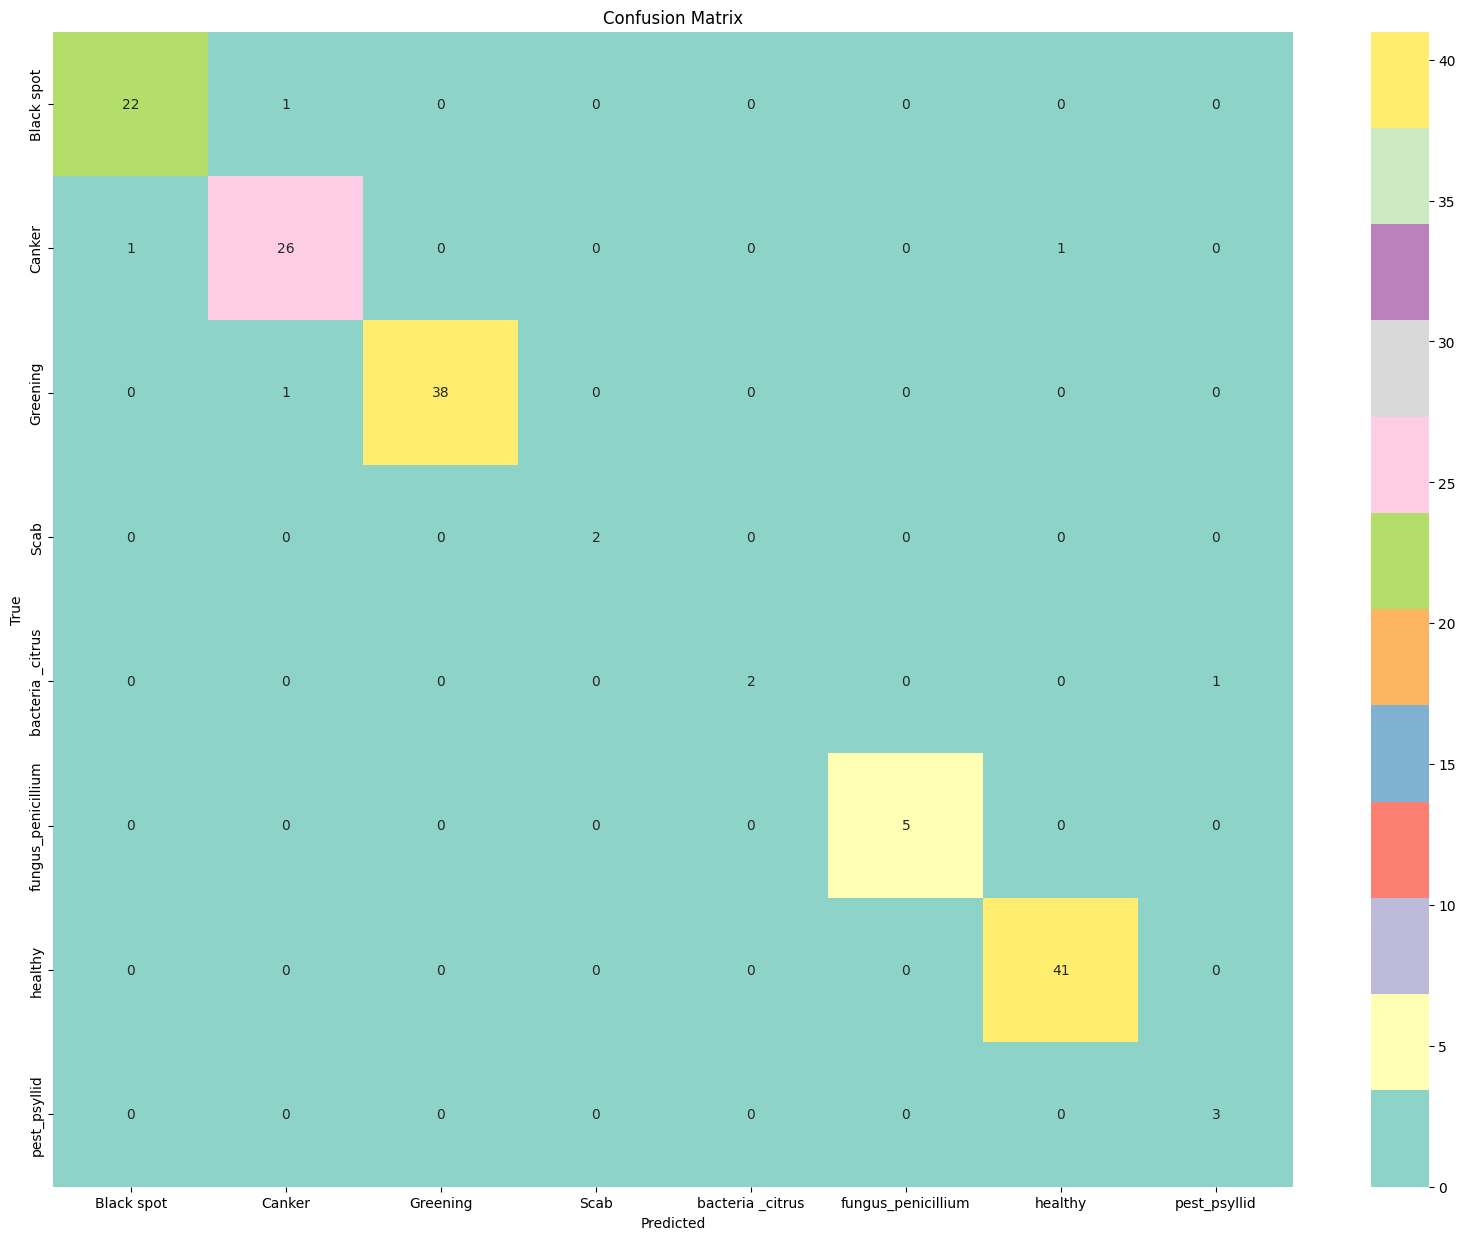

In [ ]:
# plot confusion matrix
plot_cm(cm, classes, title="Confusion Matrix")

# **III. Prediction pipeline**

In [ ]:
## 1. Load model with pre-trained weights

In [ ]:
def load_model_weights(model, weights_path, device='cpu'):
    """
    Loads the weights from a saved .pth file into a PyTorch model and checks if the weights are loaded properly.

    Parameters:
    - model: The PyTorch model to which the weights will be loaded.
    - weights_path: The path to the .pth file containing the model weights.
    - device: The device on which the model will be loaded ('cpu' or 'cuda').

    Returns:
    - model: The PyTorch model with loaded weights.
    """
    # Ensure the model is on the correct device
    model = model.to(device)

    # Load the weights into a variable
    state_dict = torch.load(weights_path, map_location=device)

    # Load the state dict into the model
    model.load_state_dict(state_dict)

    # Verifying successful loading
    try:
        model.load_state_dict(state_dict)
        print("Model weights have been successfully loaded.")
    except Exception as e:
        print("Failed to load model weights:", e)

    return model


In [ ]:
num_classes = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting up the classifier (assuming it has already been defined)
model_ef_B7_aug.classifier = nn.Sequential(
                nn.Dropout(p=config_ef_B7_aug["dropout"], inplace=True),
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(),
                nn.Dropout(p=config_ef_B7_aug["dropout"]),
                nn.Linear(1024, num_classes)
            )

# Load the model weights
weights_path = '/content/weights_efB7_aug_2 (1).pth'
model_ef_B7_aug = load_model_weights(model_ef_B7_aug, weights_path, device)

Model weights have been successfully loaded.


In [ ]:
def predict_single_image(image_path, model, device):
    # Load the image
    image = Image.open(image_path)

    # Apply transformations
    test_transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
       ])

    image_tr = test_transform(image=np.array(image))['image']
    image_tr = torch.tensor(image_tr).unsqueeze(0).to(device)

    # Make predictions
    with torch.no_grad():
        output = model(image_tr)
        probabilities = torch.softmax(output, dim=1)
        _, predicted_class = torch.max(probabilities, 1)

    return predicted_class.item(), probabilities[0, predicted_class].item()

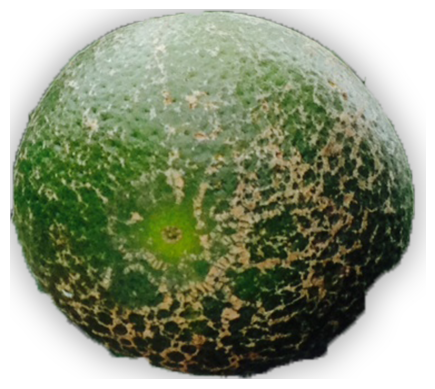

In [ ]:
random.seed(8)
test_path = '/content/drive/MyDrive/Milan-Urban-Farming/Task3-Smart Pest Management/Data collection/Image Collection/orange - Swathy/Orange fruit/Scab'
image_files = glob.glob(os.path.join(test_path,'*.jpg'))
# Select a random image file
random_image_file = random.choice(image_files)

# Load and display the random image using matplotlib
image = imread(random_image_file)
plt.imshow(image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()


In [ ]:
class_map.values()

dict_values(['Black spot', 'Canker', 'Greening', 'Scab', 'bacteria _citrus', 'fungus_penicillium', 'healthy', 'pest_psyllid'])

In [ ]:
print('Image_name : ',random_image_file)
img_path = random_image_file
predicted_label, _ = predict_single_image(image_path=img_path ,model=model_ef_B7_aug, device='cuda')
print(f"Predicted Label: {class_map[predicted_label]}")

Image_name :  /content/drive/MyDrive/Milan-Urban-Farming/Task3-Smart Pest Management/Data collection/Image Collection/orange - Swathy/Orange fruit/Scab/53.jpg
Predicted Label: Scab
